In [1]:
# ライブラリのimport

# NumPy用ライブラリ
import numpy as np

# Matplotlib中のpyplotライブラリのインポート
import matplotlib.pyplot as plt

# matplotlib日本語化対応ライブラリのインポート
import japanize_matplotlib

# pandas用ライブラリ
import pandas as pd

# データフレーム表示用関数
from IPython.display import display

# seaborn
import seaborn as sns

# 表示オプション調整
# NumPy表示形式の設定
np.set_printoptions(precision=3, floatmode="fixed")
# グラフのデフォルトフォント指定
plt.rcParams["font.size"] = 14
# サイズ設定
plt.rcParams["figure.figsize"] = (6, 6)
# 方眼表示ON
plt.rcParams["axes.grid"] = True
# データフレームでの表示精度
pd.options.display.float_format = "{:.3f}".format
# データフレームですべての項目を表示
pd.set_option("display.max_columns", None)

In [2]:
import pymc as pm
import arviz as az

print(f"Running on PyMC v{pm.__version__}")
print(f"Running on ArViz v{az.__version__}")

Running on PyMC v5.25.1
Running on ArViz v0.22.0


In [3]:
# パラメータ設定
p = 0.5
# p はベルヌーイ分布の成功確率（くじに「当たる」確率）を表すパラメータ。
# 理論的には、確率変数 X が
#
#   X ∼ Bernoulli(p)
#
# に従うとき、
#
#   P(X = 1) = p,   P(X = 0) = 1 - p
#
# という 2 値（0 or 1）の分布を表す。
# 今回は p = 0.5 としているので、「当たり」と「ハズレ」が等確率の対称なベルヌーイ分布になっている。

model1 = pm.Model()
# model1 は PyMC における「確率モデル（ベイズモデル）」のコンテナ。
# 理論的には、この model1 の中に
#
#   - パラメータ（事前分布） p(θ)
#   - 観測変数（尤度） p(x | θ)
#
# を順次定義していくことで、ベイズモデル全体
#
#   p(θ, x) = p(x | θ) p(θ)
#
# を表現することになる。
# ここではまだパラメータに事前分布は与えておらず、単一のベルヌーイ分布に従う
# 生成モデル X ~ Bernoulli(p) を記述する最小限のモデルになっている。

with model1:
    # with 文によるコンテキスト内で定義された確率変数は、すべて上で作成した model1 に登録される。
    # 理論的には、「このブロックの中に書かれる分布と変数は、同一の確率モデルの構成要素である」
    # という宣言だと思ってよい。
    #
    # pm.Bernoulli: ベルヌーイ分布の確率変数を定義するクラス。
    #   X ∼ Bernoulli(p)
    # に対応し、0/1 の 2 値をとる離散分布を表す。
    #
    # p: くじに当たる確率（成功確率）。
    #   - 理論的には「1 回の試行において X=1 となる確率」
    #   - 今回は p=0.5 固定なので、
    #
    #       P(X = 1) = 0.5,  P(X = 0) = 0.5
    #
    #     の対称なベルヌーイ分布。
    #
    # 'x': 確率変数の名前（ラベル）。
    #   - PyMC 内部では、このラベルをキーとして事前・事後サンプルにアクセスする。
    #   - 理論的には、0/1 をとるランダム変数 X をコード上で識別するためのハンドルだと考えられる。
    #
    # この時点では observed 引数を指定していないため、
    #
    #   X ∼ Bernoulli(p=0.5)
    #
    # という「生成モデル」だけが定義されている状態である。
    # もし観測データ x_obs が 0/1 のサンプルとして与えられているなら、
    #
    #   x = pm.Bernoulli('x', p=p, observed=x_obs)
    #
    # のように書くことで、
    #
    #   p(x_obs | p)
    #
    # という尤度をモデルに組み込むことができる。
    # さらに p 自体にも事前分布（例: p ∼ Beta(α, β)）を与えると、
    #
    #   p ∼ Beta(α, β)
    #   x | p ∼ Bernoulli(p)
    #
    # というベイズモデルが構成され、観測データから p の事後分布
    #
    #   p(p | x_obs) ∝ p(x_obs | p) p(p)
    #
    # を PyMC の MCMC で推定できるようになる、というのが理論的な流れである。
    x = pm.Bernoulli("x", p=p)

In [4]:
with model1:
    # with model1: によって、このブロック内で呼び出す関数は
    # すべて「先ほど定義したベルヌーイ分布モデル model1」に紐づいて実行される。
    #
    # model1 の中身（現時点）：
    #
    #   X ∼ Bernoulli(p=0.5)
    #
    # という 0/1 の確率変数が 1 つだけ存在する単純な生成モデル。
    # ここでは p 自体は確率変数ではなく「既知の定数 0.5」として扱われている。
    #
    # pm.sample_prior_predictive:
    #   ベイズ統計でいう「事前予測分布 (prior predictive distribution)」に従う
    #   サンプルを生成する関数に対応する。
    #
    # 一般のベイズモデルでは
    #
    #   θ ∼ p(θ)        （パラメータの事前分布）
    #   x ∼ p(x | θ)    （尤度／データ生成モデル）
    #
    # と書けるとき、事前予測分布は
    #
    #   p(x) = ∫ p(x | θ) p(θ) dθ
    #
    # で定義される。
    #
    # pm.sample_prior_predictive() はこの p(x) からサンプルを生成する操作を
    # 数値的に模倣しており、
    #
    #   1. θ^(s) ~ p(θ) をサンプル
    #   2. x^(s) ~ p(x | θ^(s)) をサンプル
    #
    # を繰り返すことで {x^(s)} を得る、というイメージに対応する。
    #
    # ただし今回のモデルでは θ に相当するパラメータ p が確率変数ではなく定数 0.5 なので、
    #
    #   X ∼ Bernoulli(p=0.5)
    #
    # という 1 段階の生成しかなく、
    #
    #   p(x) = p(x | p=0.5)
    #
    # という「退化した事前予測分布」になっている。
    # それでも sample_prior_predictive は、
    #   X ~ Bernoulli(0.5)
    # からのサンプル列 {X^(s)} を生成し、
    # 「このモデルが事前に想定しているデータ分布」を具体的な乱数として与えてくれる。
    #
    # random_seed=42:
    #   サンプリングに用いる乱数シードを固定することで、
    #   毎回同じ {X^(s)} が得られるようにしている。
    #   ベイズ推論はサンプルベースの推定を行うため、
    #   結果の再現性を確保するには乱数シードを明示することが重要。
    prior_samples1 = pm.sample_prior_predictive(random_seed=42)

Sampling: [x]


In [5]:
# prior_samples1 は pm.sample_prior_predictive(...) の戻り値であり、
# その中の ['prior']['x'] は、
#
#   X ∼ Bernoulli(p=0.5)
#
# という事前モデルから生成されたサンプル列 {X^(s)} を保持している。
# PyMC/ArviZ では通常、InferenceData の "prior" グループに
#   (チェーン数, ドロー数, …)
# のような形状でサンプルが格納されているため、
# .values で NumPy 配列として取り出している。
#
# 理論的には、この x_samples1 は
#
#   X^(s) ∈ {0, 1}  ,  s = 1, …, S
#
# というベルヌーイ分布 Bernoulli(0.5) に従う標本であり、
# 経験分布を通じて真の分布
#
#   P(X = 1) = 0.5,  P(X = 0) = 0.5
#
# をサンプルベースで近似していると解釈できる。
x_samples1 = prior_samples1["prior"]["x"].values

# 生成されたサンプル列をそのまま出力する。
# 出力される値は 0 と 1 のみからなり、
#   - 1 の比率が「当たり」の経験的な確率
#   - 0 の比率が「ハズレ」の経験的な確率
# に対応する。
#
# サンプルサイズを S とすると、
#
#   1 の経験頻度
#     \hat{p} = (1/S) ∑_{s=1}^S 1{X^(s) = 1}
#
# は大数の法則により S → ∞ のとき真の p = 0.5 に収束する。
# したがって、この print 出力を眺めること自体が、
# 「事前モデル Bernoulli(0.5) からのサンプルが期待通り 0/1 を半々くらいで出しているか」
# を感覚的に確認する簡易チェックになっている。
print(x_samples1)

[[1 1 1 0 1 0 1 1 0 0 1 0 0 1 0 0 1 0 1 1 0 0 1 1 0 1 0 1 1 1 0 1 0 1 1 1
  0 1 1 0 0 1 1 0 1 1 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 0
  0 0 1 1 0 1 1 1 0 0 1 1 0 0 0 0 1 1 0 0 0 1 0 0 1 1 0 0 0 1 0 1 1 1 0 1
  1 1 0 1 1 1 0 1 1 0 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1
  1 1 0 1 0 1 1 0 1 1 1 1 0 1 1 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 1 1 1 1
  0 0 1 0 0 1 0 1 1 0 0 0 0 1 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 0 1 1 0 0 1
  1 0 1 0 0 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 0 1 0 1 1 1 1 0 1 0 1 0 0 1 1 1
  0 0 0 1 0 0 1 0 1 1 1 0 0 1 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 1 1 1 0 1
  1 0 0 1 0 0 0 0 1 1 0 1 0 1 1 1 0 1 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 1 1 0
  1 0 1 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 0 0 1 1 1 0
  1 0 1 0 0 1 0 0 1 0 1 0 0 0 1 0 1 1 0 1 1 0 0 0 0 1 1 1 0 0 0 0 1 0 1 1
  0 0 0 1 0 1 0 0 0 1 0 0 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 0
  1 0 0 0 1 1 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 1 0 1 1 0 0 0 1
  0 1 0 0 0 1 0 0 1 1 1 1 0 0 0 1 0 0 

In [6]:
# ArviZ の summary 関数を用いて、事前サンプル prior_samples1 の要約統計量を計算する。
# az.summary(...) は本来、事後サンプル（posterior）に対して
#   - 平均 (mean)
#   - 標準偏差 (sd)
#   - HDI（Highest Density Interval：最も密度の高い信用区間）
#   - ESS（有効サンプルサイズ）
#   - R-hat（収束診断指標）
# などを表形式で返すための関数だが、
# InferenceData であれば prior（事前）にも同様の統計量を計算できる。
#
# 今回 prior_samples1 は
#
#   X ∼ Bernoulli(p=0.5)
#
# からの事前サンプル {X^(s)} を含んでいる。
# 理論的には、X の分布は
#
#   P(X = 1) = 0.5,  P(X = 0) = 0.5
#
# なので、
#
#   期待値:
#
# $$
# \mathbb{E}[X] = 0 \cdot (1 - p) + 1 \cdot p = p = 0.5
# $$
#
#   分散:
#
# $$
# \mathrm{Var}(X) = p(1 - p) = 0.25
# $$
#
#   標準偏差:
#
# $$
# \sigma = \sqrt{0.25} = 0.5
# $$
#
# となる。
#
# az.summary(prior_samples1, kind='stats') は、サンプル {X^(s)} に基づいて
# これらの量をモンテカルロ的に推定していると解釈できる。
# サンプル数 S が十分大きければ、
#
#   - summary1["mean"] ≈ 0.5
#   - summary1["sd"]   ≈ 0.5
#
# となり、理論値と良い一致を示すはずである。
# これは「PyMC の事前サンプルが、期待したベルヌーイ分布 Bernoulli(0.5) に従っているか」を
# 数値的にチェックする一つの方法になっている。
summary1 = az.summary(prior_samples1, kind="stats")

# 得られた要約統計量 summary1 を表示する。
# Jupyter 環境では display(summary1) によって、pandas の DataFrame 形式の表が見やすくレンダリングされる。
# 表の中の mean, sd, hdi_xx などの値を理論値と比較することで、
# 事前分布（あるいは事前予測分布）の統計的な性質が
# 想定しているモデル（ここでは Bernoulli(0.5)）と整合しているかを確認できる。
display(summary1)

,mean,sd,hdi_3%,hdi_97%
x,0.512,0.500,0.000,1.000


Text(0.5, 1.0, 'ベルヌーイ分布\u3000p=0.5')

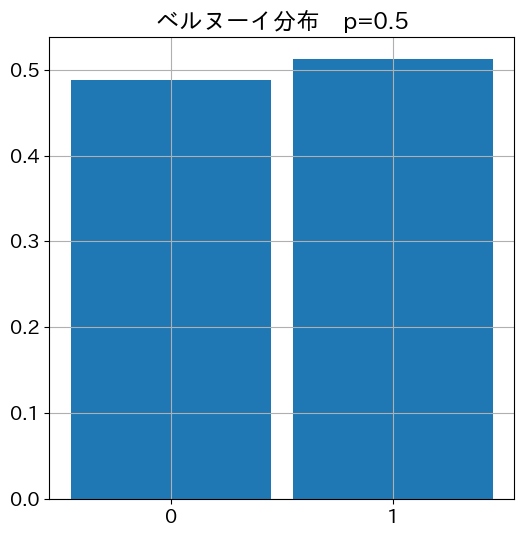

In [7]:
# ArviZ を用いて、ベルヌーイ分布からの事前サンプル x_samples1 の分布を可視化する。
# x_samples1 は
#
#   X^{(s)} ∈ {0, 1},  s = 1, …, S
#
# というサンプル列であり、理論的には
#
#   X ∼ Bernoulli(p)
#
# の事前分布（あるいは事前予測分布）からの標本とみなせる。
# 大数の法則により、サンプル数 S → ∞ のとき、経験分布は真の分布
#
#   P(X = 1) = p,   P(X = 0) = 1 - p
#
# に収束するので、このプロットは有限サンプルに基づく「ベルヌーイ分布の経験的な形」を示している。
ax = az.plot_dist(x_samples1)

# プロットにタイトルを付ける。
# タイトル 'ベルヌーイ分布 p=0.5'（具体的には f 文字列で p の値を埋め込む）は、
# この図が「どの確率分布に対応するサンプルを可視化したものか」を明示する役割を持つ。
#
# 理論的には、ここで描画されているのは
#
#   X ∼ Bernoulli(p)
#
# の経験分布（サンプルベースの近似）であり、
# - p が 0.5 であれば 0 と 1 がほぼ半々で現れる対称な形
# - p が 0.8 などに変われば、1 側に質量が偏った形
#
# になるはずである。
# つまり、同じコードで p の値を変えながら x_samples1 を取り直し可視化することで、
# 「ベルヌーイ分布のパラメータ p が変わると分布の形がどう変わるか」を
# ベイズ的なサンプル視点から確認できる。
ax.set_title(f"ベルヌーイ分布　p={p}")

In [8]:
# パラメータ設定
p = 0.5
# p は二項分布における「1 回の試行で成功する確率」を表すパラメータ。
# 理論的には、成功確率 p のベルヌーイ試行を n 回独立に繰り返したときの
#
#   各試行の結果: Y_i ∼ Bernoulli(p),  i = 1, …, n
#
# に対して、「成功回数」
#
#   X = Y_1 + Y_2 + … + Y_n
#
# が従う分布が二項分布 Binomial(n, p) である。
# 今回は p = 0.5 としているので、各試行で「当たり」と「ハズレ」が等確率になっている。

n = 5
# n は二項分布における試行回数（ベルヌーイ試行を何回繰り返すか）を表す。
# 理論的には、X が取りうる値は
#
#   X ∈ {0, 1, 2, …, n}
#
# であり、確率質量関数 (PMF) は
#
#   P(X = k) = C(n, k) p^k (1-p)^{n-k},   k = 0, …, n
#
# で与えられる。ここでは n = 5 なので、最大 5 回まで当たる可能性がある「5 回くじを引いたときの当たり回数」
# を表す確率変数になっていると解釈できる。

model2 = pm.Model()
# model2 は PyMC における確率モデル（ベイズモデル）を保持するコンテナ。
# 理論的には、この中に
#
#   - パラメータの事前分布 p(θ)
#   - 観測データの尤度 p(x | θ)
#
# を定義することで、結合分布
#
#   p(θ, x) = p(x | θ) p(θ)
#
# を表現する。ここでは、まだパラメータに事前分布を与えておらず、
#
#   X ∼ Binomial(n=5, p=0.5)
#
# という「生成モデル（データ生成分布）」のみを記述したモデルになっている。

with model2:
    # with model2: によって、このブロック内で定義される確率変数はすべて model2 に登録される。
    # 「このブロックの中身は同じ確率モデルの構成要素である」という宣言と考えてよい。
    #
    # pm.Binomial: 二項分布に従う確率変数 X を定義するクラス。
    # 理論的には
    #
    #   X ∼ Binomial(n, p)
    #
    # であり、確率質量関数は
    #
    #   P(X = k) = C(n, k) p^k (1-p)^{n-k},   k = 0, …, n
    #
    # で与えられる。
    #
    # p: 1 回の試行で成功する確率。
    #   - ここでは p = 0.5 なので、各試行は公平なくじ引きに相当する。
    #
    # n: 試行回数。
    #   - ここでは n = 5 であり、「5 回の独立なベルヌーイ試行の成功回数」を表す。
    #
    # 'x': この二項分布に従う確率変数を識別するための名前（ラベル）。
    #   - PyMC 内部では 'x' をキーとして、この変数のサンプルや事前・事後分布にアクセスする。
    #
    # なお、この時点では observed 引数を指定していないため、
    #
    #   X ∼ Binomial(n=5, p=0.5)
    #
    # という「データ生成モデル」だけが定義されている状態である。
    # もし実際の観測データ（例: 実験で 5 回くじを引いた結果の成功回数）が x_obs として与えられていれば、
    #
    #   x = pm.Binomial('x', p=p, n=n, observed=x_obs)
    #
    # のように書くことで、「観測された成功回数 x_obs が得られる尤度」
    #
    #   p(x_obs | p, n)
    #
    # をモデルに組み込むことができる。
    # さらに p 自体にも事前分布（例: p ∼ Beta(α, β)）を与えると、
    #
    #   p ∼ Beta(α, β)
    #   X | p ∼ Binomial(n, p)
    #
    # という完全なベイズモデルが構成され、観測データから p の事後分布
    #
    #   p(p | x_obs) ∝ p(x_obs | p) p(p)
    #
    # を MCMC などで推論できるようになる、というのが理論的な流れになる。
    x = pm.Binomial("x", p=p, n=n)

Sampling: [x]


[[4 4 4 2 4 1 5 3 1 2 3 1 2 4 2 1 4 0 3 3 1 2 3 4 1 3 1 3 3 3 2 3 1 3 3 3
  0 4 3 1 2 4 3 1 3 3 2 1 1 3 3 2 2 4 4 3 4 3 4 3 5 4 3 2 3 3 3 1 1 2 1 2
  1 1 3 3 2 3 3 4 1 1 3 3 2 2 2 2 3 3 2 2 1 3 2 0 3 4 2 2 2 3 2 4 4 4 1 4
  5 3 1 4 3 3 1 3 3 2 2 3 2 3 3 4 4 1 3 3 4 3 3 4 3 5 3 3 3 2 4 3 3 2 3 3
  3 4 1 4 2 4 3 1 4 4 3 4 2 3 5 2 0 3 2 2 2 3 0 0 2 1 2 4 1 2 3 2 3 3 3 3
  2 1 3 2 2 4 2 3 3 2 2 2 1 3 1 1 3 2 3 1 3 4 3 2 2 2 2 1 2 2 2 4 4 2 2 4
  3 2 3 2 0 3 3 4 3 3 4 2 3 3 2 3 3 1 4 3 1 3 2 4 4 3 4 1 5 2 3 2 2 3 3 4
  2 1 2 4 2 2 3 1 3 3 4 2 2 4 2 2 2 4 2 1 3 2 4 2 2 3 1 2 1 2 1 4 3 5 1 3
  3 2 1 4 2 1 1 2 3 4 2 3 1 3 5 3 2 3 2 2 1 4 3 4 4 3 3 2 2 1 2 2 2 3 4 1
  3 2 3 1 4 2 1 3 3 1 2 3 2 1 1 2 1 2 2 2 2 5 2 2 1 2 4 4 3 3 1 2 5 3 3 2
  4 2 4 2 0 4 2 1 3 2 3 2 1 1 3 1 3 3 2 3 3 2 1 1 1 4 3 3 2 1 2 2 5 2 3 3
  2 1 2 4 2 4 2 2 0 3 2 2 3 1 1 4 3 3 4 4 3 4 1 5 4 3 3 5 3 4 3 3 2 2 3 2
  4 1 1 2 3 3 4 2 2 2 2 3 2 2 4 2 0 2 3 1 2 2 3 4 3 3 3 1 4 0 4 4 2 2 1 4
  1 3 2 0 0 3 2 2 3 3 4 4 2 1 2 3 2 2 

,mean,sd,hdi_3%,hdi_97%
x,2.522,1.103,1.000,4.000


Text(0.5, 1.0, '二項分布\u3000p=0.5 n=5')

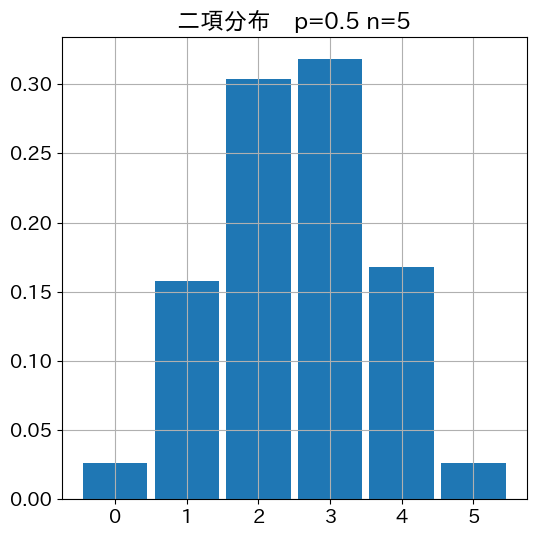

In [9]:
# with model2: のコンテキストに入ることで，
# 以降の PyMC の処理が「二項分布モデル」
#
#   X ∼ Binomial(n=5, p=0.5)
#
# に対して行われることを明示している。
with model2:
    # pm.sample_prior_predictive は，「事前（prior）からのサンプリング」
    # というより正確には「事前予測分布 (prior predictive distribution)」からの
    # サンプリングに対応する。
    #
    # 一般のベイズモデルでは
    #
    #   θ ∼ p(θ)              （パラメータの事前分布）
    #   X ∼ p(X | θ)          （データ生成分布／尤度）
    #
    # と書けるとき，事前予測分布 p(x) は
    #
    #   p(x) = ∫ p(x | θ) p(θ) dθ
    #
    # で定義される。
    # pm.sample_prior_predictive() は，この p(x) からのサンプルを
    # サンプリングによって近似的に生成する操作に対応している。
    #
    # 今回の model2 では，成功確率 p を「確率変数」ではなく
    # 固定値 p=0.5 として与えているので，
    #
    #   p(θ) = δ(θ - 0.5)   （p に関する退化事前分布）
    #
    # という状況になっており，上の積分は
    #
    #   p(x) = ∫ p(x | p) δ(p - 0.5) dp = p(x | p=0.5)
    #
    # に簡約される。したがって，
    #
    #   X ∼ Binomial(n=5, p=0.5)
    #
    # という分布から直接サンプルしているのと同じ意味になる。
    #
    # random_seed=42 は乱数シードを固定するための指定であり，
    # 毎回同じ乱数列（サンプル列）を再現できるようにするために重要。
    # ベイズ推論ではサンプルベースの手法（MCMC 等）を多用するため，
    # 再現性の観点から乱数シードを明示するのは良い実践である。
    prior_samples2 = pm.sample_prior_predictive(random_seed=42)


# サンプル値抽出
# prior_samples2 は PyMC/ArviZ が返す InferenceData 形式のオブジェクトで，
# "prior" グループの中に事前サンプルが格納されている。
# ここで 'x' は model2 で定義した二項分布の確率変数 X に対応する。
#
#   prior_samples2['prior']['x'].values
#
# によって，二項分布からのサンプル列
#
#   { X^(s) }_{s=1}^S
#
# を NumPy 配列として取り出していると解釈できる。
# 各 X^(s) は 0,1,2,3,4,5 のいずれかの値をとり，
# 理論上は
#
#   P(X = k) = C(5, k) (0.5)^k (0.5)^{5-k}
#
# に従う。
x_samples2 = prior_samples2["prior"]["x"].values
print(x_samples2)
# この print によって，実際にサンプリングされた成功回数の列が表示される。
# サンプル数 S が十分大きいとき，経験頻度
#
#   N_k / S   （N_k は「X = k となったサンプル数」）
#
# は理論値 P(X = k) に近づいていく（大数の法則）。


# サンプリング結果の統計分析
# az.summary(prior_samples2, kind='stats') は，
# InferenceData に含まれるサンプルに対して要約統計量を計算する。
#
# 二項分布
#
#   X ∼ Binomial(n, p)
#
# に対して，理論的な期待値と分散は
#
#   E[X]      = n p
#   Var(X)    = n p (1 - p)
#   SD(X)     = √{ n p (1 - p) }
#
# で与えられる。
# 今回は n=5, p=0.5 なので，
#
#   E[X]      = 5 × 0.5 = 2.5
#   Var(X)    = 5 × 0.5 × 0.5 = 1.25
#   SD(X)     = √1.25 ≒ 1.118
#
# となるはずである。
#
# summary2 に表示される mean, sd などは，
# サンプル { X^(s) } に基づくモンテカルロ推定値に相当し，
# サンプル数が多ければ上記の理論値に近づく。
# これにより，「PyMC の事前サンプルが二項分布の理論と整合しているか」を
# 数値的にチェックできる。
summary2 = az.summary(prior_samples2, kind="stats")
display(summary2)


# サンプリング結果の可視化
# az.plot_dist(x_samples2) は，サンプル列 x_samples2 の「経験分布」を可視化する。
# 理論的には，サンプル列
#
#   { X^(s) }_{s=1}^S
#
# に対して，経験分布
#
#   \hat{P}(X = k) = N_k / S
#
# を描いているとみなせる。サンプル数 S → ∞ の極限では，
# この経験分布が真の二項分布の PMF に収束する。
#
# ここで描かれるのは「理論式そのもの」ではなく
# 「有限サンプルにもとづく近似」である点に注意。
# それでも十分なサンプル数があれば，
# 棒グラフ／密度の形が「山型」の二項分布らしい形になることが
# 視覚的に確認できる。
ax = az.plot_dist(x_samples2)

# タイトルでは，このプロットが
#
#   X ∼ Binomial(n, p)
#
# という二項分布に対応していることを明示している。
# p と n の値をタイトルに含めることで，
# 「どのパラメータ設定の二項分布からサンプルした結果か」が
# 一目で分かるようになっており，
# 可視化と理論モデルの紐付けとして良い書き方になっている。
ax.set_title(f"二項分布　p={p} n={n}")

Sampling: [x]


[[30 30 29 23 31 22 34 27 21 24 26 22 23 30 25 20 30 17 27 25 22 24 28 29
  20 26 21 26 27 28 23 26 20 26 28 27 18 29 27 19 22 29 26 21 27 28 23 19
  20 25 25 22 24 31 29 26 31 26 29 27 32 30 26 24 27 25 26 20 19 23 20 24
  19 21 26 25 25 28 26 28 20 20 27 26 22 24 24 25 25 26 25 22 20 27 24 18
  26 29 24 23 24 27 22 28 29 30 19 30 32 28 19 28 26 26 22 27 25 24 25 27
  23 26 27 30 30 20 28 26 28 26 27 30 26 32 28 26 27 23 31 27 26 23 28 26
  25 29 20 28 25 30 27 20 29 28 26 30 23 28 32 24 18 27 24 24 23 25 17 16
  24 20 25 30 21 24 26 22 27 27 28 26 23 21 25 24 22 30 23 26 26 22 24 24
  21 26 21 21 26 22 28 19 27 31 26 24 23 22 24 20 24 25 22 29 28 22 23 30
  27 25 28 23 17 25 26 31 28 27 29 24 27 26 24 25 27 22 29 25 20 26 23 29
  30 27 29 21 32 22 26 23 22 27 27 29 25 20 22 29 23 24 25 20 27 25 28 23
  24 31 22 24 24 29 25 22 26 25 28 25 24 27 21 22 22 24 19 29 27 34 19 26
  26 24 19 30 25 20 21 25 27 32 25 26 19 26 34 28 24 25 25 25 19 29 26 28
  28 27 26 25 23 21 24 24 22 25 30 22 

,mean,sd,hdi_3%,hdi_97%
x,24.998,3.456,18.000,30.000


Text(0.5, 1.0, '二項分布\u3000p=0.5 n=50')

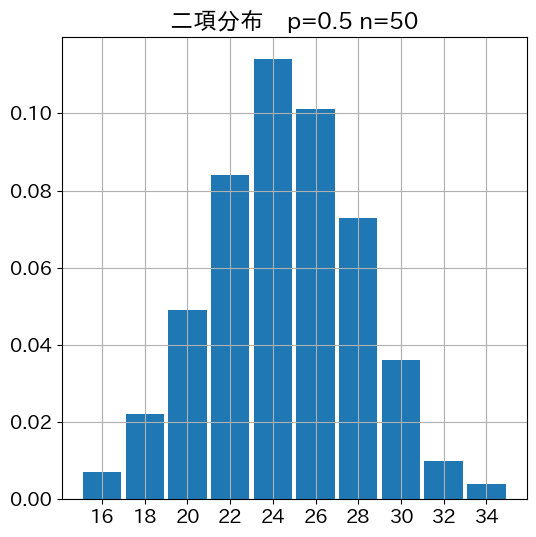

In [10]:
# パラメータ設定
p = 0.5
n = 50

model3 = pm.Model()
with model3:
    # pm.Binomial: 二項分布
    # p: くじに当たる確率
    # n: 試行回数
    x = pm.Binomial("x", p=p, n=n)

    # サンプリング
    prior_samples3 = pm.sample_prior_predictive(random_seed=42)

# サンプル値の抽出
x_samples3 = prior_samples3["prior"]["x"].values
print(x_samples3)

# サンプリング結果の統計分析
summary3 = az.summary(prior_samples3, kind="stats")
display(summary3)

# サンプリング結果の可視化
ax = az.plot_dist(x_samples3)
ax.set_title(f"二項分布　p={p} n={n}")

([<matplotlib.axis.XTick at 0x17514b670>,
 [Text(4.0, 0, '4.0'),
  Text(4.2, 0, '4.2'),
  Text(4.4, 0, '4.4'),
  Text(4.6000000000000005, 0, '4.6'),
  Text(4.800000000000001, 0, '4.8'),
  Text(5.000000000000001, 0, '5.0'),
  Text(5.200000000000001, 0, '5.2'),
  Text(5.400000000000001, 0, '5.4'),
  Text(5.600000000000001, 0, '5.6'),
  Text(5.800000000000002, 0, '5.8'),
  Text(6.000000000000002, 0, '6.0')])

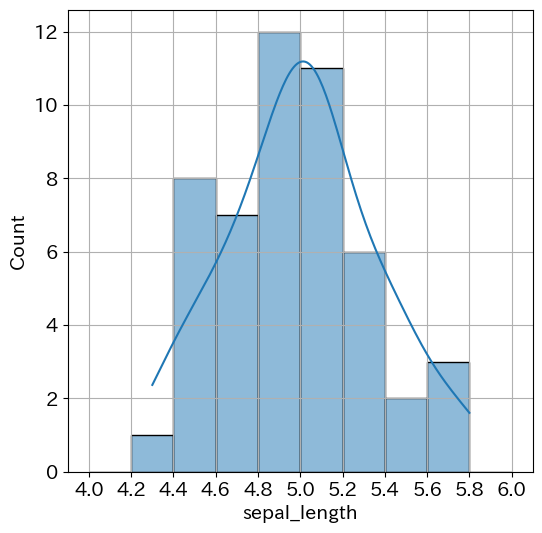

In [11]:
# アイリスデータセットの読み込み
# seaborn の load_dataset('iris') は、Fisher の有名なアイリスデータセットを返す。
# このデータは、花びら・がく片の「長さ」「幅」と「品種（species）」の 4 + 1 変数からなる
# 多変量データであり、統計・機械学習の入門で頻出する。
# 理論的には、連続変数（sepal_length, sepal_width, petal_length, petal_width）と
# カテゴリ変数（species）からなるサンプル集合
#   { (x_i, y_i) }_{i=1}^n
# を観測しているとみなせる。
df = sns.load_dataset("iris")

# setosaの行のみ抽出
# ここでは「品種が setosa である」という条件付き分布を取り出している。
# すなわち、元の標本集合 { (x_i, y_i) } から y_i = "setosa" を満たすサンプルだけを抽出し、
# 「品種を setosa に固定したときの sepal_length の分布」を見ていることになる。
# 理論的には、元の確率変数を (X, Y) としたときに、
#   条件付き分布  X | (Y = setosa)
# の実現値だけを集めて、その経験分布を解析していると解釈できる。
df1 = df.query('species == "setosa"')

# bins の設定
# np.arange(4.0, 6.2, 0.2) により、[4.0, 6.0] を幅 0.2 の区間に区切るビン境界を定義している。
# 連続変数 X = sepal_length を histogram で可視化する場合、
#   各ビン [a_j, a_{j+1}) の中に落ちた標本の個数を数え、
#   それを標本数 n で割ることで経験的な「確率」を近似する。
# ビン幅を Δx とすると、密度関数 f(x) に対して
#   P(a_j ≤ X < a_{j+1}) ≒ f(ξ_j) Δx   （ξ_j は区間内のどこかの点）
# という関係があるので、ビン内の相対頻度を Δx で割ることで
# 「確率密度」の近似が得られる（標本数 n を大きくし、ビン幅 Δx を小さくすると、
# 大数の法則のもとで真の密度関数に近づいていく）。
bins = np.arange(4.0, 6.2, 0.2)

# 分布の確認
# sns.histplot は、指定された変数のヒストグラムを描画する。
# ここでは df1（setosa のみ）に対して x='sepal_length' を指定しているので、
#   X = sepal_length | (species = setosa)
# という「条件付き連続確率変数 X」の経験分布を可視化していることになる。
# 引数 bins=bins でビン境界を上で定義したものに固定しているため、
# 各ビン [4.0, 4.2), [4.2, 4.4), ... といった区間ごとの頻度を比較できる。
#
# kde=True により、カーネル密度推定（Kernel Density Estimation）がヒストグラムの上に重ねて描画される。
# KDE は、標本 {x_i} から連続な確率密度関数 f(x) を推定する非パラメトリックな方法であり、
#
#   f̂(x) = (1 / (n h)) Σ K((x - x_i) / h)
#
# のように、各標本点の周りにカーネル関数 K（例えばガウス分布）を置いて平滑化したものを合計する。
# 理論的には、標本数 n → ∞, バンド幅 h → 0 を適切な速度で取りつつ、
# いくつかの正則性条件を満たせば f̂(x) は真の密度 f(x) に収束することが知られている。
# したがって、このプロットは
#   - 棒グラフ: 実際の標本から得られる経験的な頻度（離散的な近似）
#   - 曲線（KDE）: 連続的な密度関数の推定
# を同時に見せることで、setosa の sepal_length がどのあたりに集中しているかを
# 直感的に理解するためのものになっている。
sns.histplot(df1, x="sepal_length", bins=bins, kde=True)

# x 軸の目盛りを bins の境界に合わせて設定している。
# これにより、ヒストグラムの各棒と x 軸の目盛りが 1 対 1 に対応し、
# 「どの区間にどれくらいの標本が来ているか」を読み取りやすくしている。
plt.xticks(bins)

Text(0.5, 1.0, '正規分布関数のグラフ')

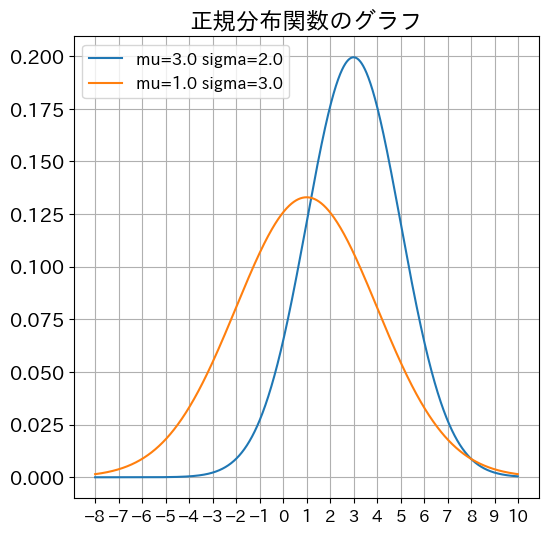

In [12]:
# 正規分布関数の定義
# 式(2.3)をNumPyで実装
# 正規分布の確率密度関数 (PDF) は
#
#   N(x | μ, σ^2) =
#     1 / (√(2π) σ) * exp{ - (x - μ)^2 / (2 σ^2) }
#
# で与えられる。
# ここでは μ（平均）と σ（標準偏差）をパラメータとして受け取り、
# 任意の x に対してこの PDF の値を返す関数を NumPy で実装している。
def norm(x, mu, sigma):
    # (x - mu)/sigma は「標準化」であり、元の変数 X を
    #
    #   Z = (X - μ) / σ
    #
    # と変換して標準正規分布 N(0, 1) に従う変数に変換する操作に対応する。
    # その二乗を 2 で割ったものが指数の中の
    #
    #   (x - μ)^2 / (2 σ^2)
    #
    # の部分に対応する。
    # 母数 μ, σ の値によって「山の位置」と「広がり」が変化する。
    return np.exp(-(((x - mu) / sigma) ** 2) / 2) / (np.sqrt(2 * np.pi) * sigma)
    # 分母の np.sqrt(2 * np.pi) * sigma は
    #
    #   1 / (√(2π) σ)
    #
    # の部分に対応し、「確率密度が全区間で積分すると 1 になるようにする」
    # 正規化定数である。
    # もしこの正規化定数がなければ、曲線の形は同じでも、
    # 総和（積分値）が 1 にならず、確率密度とは呼べなくなる。


# パラメータ定義
mu1, sigma1 = 3.0, 2.0
mu2, sigma2 = 1.0, 3.0
# mu1, mu2 はそれぞれの正規分布の平均（期待値）であり、
#
#   E[X] = μ
#
# に対応する。グラフ上では「山の中心（ピーク）」の位置になる。
#
# sigma1, sigma2 は標準偏差であり、グラフの「広がり」の指標となる。
# 理論的には
#
#   Var(X) = σ^2
#
# であり、σ が大きいほど分布は横に広く、ピークは低くなる。
# 今回の設定では
#   - N(3, 2^2) : 平均 3, 標準偏差 2
#   - N(1, 3^2) : 平均 1, 標準偏差 3
# の 2 つの正規分布を重ねて可視化している。

# グラフ描画用x座標の定義
# 2つの正規分布関数で±3sigmaまで入るように計算
# 正規分布の「ほとんどの質量」は平均 ± 3σ の範囲に含まれることが知られている。
# これは 3σ ルールと呼ばれ、
#
#   P(μ - 3σ ≤ X ≤ μ + 3σ) ≈ 0.997
#
# という経験則に対応する。
# ここでは 2 つの分布
#   N(3, 2^2) → おおよそ [-3, 9] 付近まで
#   N(1, 3^2) → おおよそ [-8, 10] 付近まで
# をカバーするように、x 範囲を [-8, 10] に設定している。
# ステップ幅 0.01 で細かく刻むことで、滑らかな曲線に近い描画ができる。
x = np.arange(-8.0, 10.0, 0.01)

# x軸目盛の設定
xticks = np.arange(-8.0, 11.0, 1.0)
# 目盛りを 1 刻みで設定することで、平均からの距離（何単位ずれているか）を
# 直感的に読み取りやすくしている。
# 例えば μ=3 の分布に対して x=1, 5 はそれぞれ
#   (1 - 3) / 2 = -1
#   (5 - 3) / 2 =  1
# と、標準化後の Z で ±1 に対応しており、
# 「±1σ 付近」という解釈ができる。

# グラフ描画
# ここで norm(x, mu1, sigma1) は
#
#   f_1(x) = N(x | μ1=3, σ1^2=4)
#
# に対応し、norm(x, mu2, sigma2) は
#
#   f_2(x) = N(x | μ2=1, σ2^2=9)
#
# に対応する。
# 2 つを同じ x 軸上にプロットすることで、
#   - 平均が異なると山の位置がどれだけずれるか
#   - 標準偏差が異なると山の高さや広がりがどう変わるか
# を視覚的に比較できる。
plt.plot(x, norm(x, mu1, sigma1), label=f"mu={mu1} sigma={sigma1}")
plt.plot(x, norm(x, mu2, sigma2), label=f"mu={mu2} sigma={sigma2}")

# x 軸目盛と凡例・タイトルの設定
plt.xticks(xticks, fontsize=12)
plt.legend(fontsize=12)
plt.title(f"正規分布関数のグラフ")
# この図全体は、「正規分布のパラメータ (μ, σ) が変わると形がどう変わるか」を示す例になっている。
# 理論的には、どちらも
#
#   X_1 ∼ N(3, 2^2),   X_2 ∼ N(1, 3^2)
#
# という連続確率変数であり、
#   - μ の違い：グラフの「位置（中心）」をシフトする
#   - σ の違い：グラフの「広がりと高さ」を変える
# という役割を果たすことを視覚的に確認できる。
# また、どちらの曲線も積分すると 1 になるように規格化されているため、
# 面積の観点から「どの x 付近に確率質量が集中しているか」を読み取ることができる。

In [13]:
# パラメータ設定
mu = 0.0
sigma = 1.0
# mu, sigma は正規分布 N(μ, σ^2) のパラメータであり、
#
#   X ∼ N(μ, σ^2)
#
# のとき
#
#   E[X]      = μ          （平均・期待値）
#   Var(X)    = σ^2        （分散）
#
# を意味する。
# 今回は mu=0, sigma=1 なので、
#
#   X ∼ N(0, 1)
#
# すなわち標準正規分布（standard normal distribution）を仮定している。
# 標準正規分布は、他の任意の正規分布 N(μ, σ^2) を
#
#   Z = (X - μ) / σ
#
# によって標準化したときに得られる基準分布であり、理論的にも実装的にも
# 最も基本となる正規分布である。

model4 = pm.Model()
# model4 は PyMC における「確率モデルのコンテナ」に相当する。
# 理論的には、ベイズモデル全体で扱う確率変数群
#
#   θ（パラメータ）、X（観測データ）、Z（潜在変数）...
#
# の依存関係をまとめて保持している「グラフィカルモデル」の器だと考えられる。
# 単一の N(0,1) であっても、
#
#   X ∼ N(0, 1)
#
# という生成分布（prior や latent variable の事前分布）を表現するモデルとして
# 定式化しておくことで、後続の
#   - 事前サンプリング（sample_prior_predictive）
#   - 事後サンプリング（sample）
#   - 事後予測（sample_posterior_predictive）
# などのベイズ推論の標準的なワークフローを適用できるようになる。

with model4:
    # with model4: により、このブロック内で定義される確率変数はすべて
    # 「model4 という同一の確率モデル」に紐付けられる。
    # PyMC の文脈では、「どの Model に属する変数か」を明示する役割を持つ。
    #
    # pm.Normal: 正規分布に従う確率変数を定義するクラス。
    # 理論的には、
    #
    #   X ∼ N(μ, σ^2)
    #
    # という連続確率変数 X を 1 つ導入していることに対応する。
    # 具体的な確率密度関数は
    #
    #   p(x | μ, σ) =
    #     1 / (√(2π) σ) * exp{ - (x - μ)^2 / (2 σ^2) }
    #
    # であり、ここでは μ=0, σ=1 なので
    #
    #   p(x | 0, 1) = 1 / √(2π) * exp{ - x^2 / 2 }
    #
    # となる。
    #
    # mu: 平均（location parameter）
    #   - 分布の「中心」（山の位置）を決める。
    #   - E[X] = μ となる。
    #
    # sigma: 標準偏差（scale parameter）
    #   - 分布の「広がり」「ばらつき」の大きさを決める。
    #   - Var(X) = σ^2 となる。
    #
    # 今回は mu=0, sigma=1 で標準正規分布なので、
    #   - 中心は 0
    #   - 質量のほとんどはおおよそ [-3, 3] の範囲（3σ ルール）
    # に集中する。
    #
    # 'x' という名前は、この確率変数にアクセスする際のラベルであり、
    #   - 事前サンプル (: prior)
    #   - 事後サンプル (: posterior)
    #   - 事後予測 (: posterior_predictive)
    # などで「どの変数のサンプルか」を識別するために使われる。
    # もしこの x に observed 引数を与えれば、
    #
    #   x = pm.Normal('x', mu=mu, sigma=sigma, observed=data)
    #
    # のようにして、観測データ data が
    #
    #   X_i ∼ N(μ, σ^2)
    #
    # に従うという尤度モデル
    #
    #   p(data | μ, σ)
    #
    # を定義することになり、その上で μ, σ に事前分布を置けば、
    # ベイズ推論によって μ, σ の事後分布を推定する、といった拡張につながる。
    x = pm.Normal("x", mu=mu, sigma=sigma)

Sampling: [x]


[[ 0.418  0.606  0.029 -1.084  1.464  0.291 -1.331 -0.035  0.280  0.107
  -1.921  1.579  1.006  0.451 -0.593  0.094  1.852 -0.256 -0.283  0.416
  -1.089 -1.967  0.887 -1.328 -0.132 -0.362  0.782  0.283 -1.006  0.019
  -1.243  2.603  0.151 -0.516 -0.220  0.402  1.361  0.743  0.937  0.175
   1.525  0.098 -1.165  0.524 -1.066 -0.311  0.556 -0.100 -0.258 -1.590
  -1.815  0.536  1.271 -0.554  1.724 -0.312  0.063  1.382  0.585 -0.510
   0.251  0.406  0.866 -0.534 -0.039  1.143 -0.464  2.267 -0.529  0.325
  -0.154 -0.820 -1.203  0.095 -1.362  0.277  0.307 -1.404 -1.539  1.597
   1.268 -0.744 -1.379 -0.373  0.225 -0.797 -0.190  0.405 -1.567  1.622
  -0.559  1.285 -0.649  0.642  2.170 -0.549  0.032 -0.744  1.306  0.870]]


Text(0.5, 1.0, '正規分布\u3000mu=0.0 sigma=1.0')

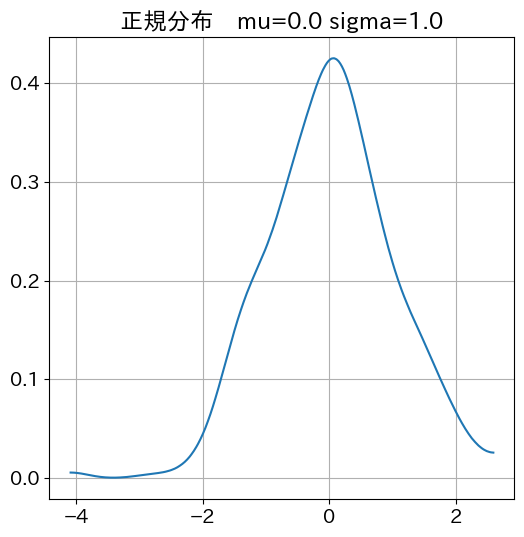

In [14]:
with model4:
    # サンプリング
    # sample_prior_predictive は「事前予測分布」からのサンプルを生成する関数である。
    #
    # 一般のベイズモデルでは、
    #
    #   θ ∼ p(θ)              （パラメータの事前分布）
    #   X ∼ p(X | θ)          （データ生成分布／尤度）
    #
    # と書けるとき、事前予測分布 p(x) は
    #
    #   p(x) = ∫ p(x | θ) p(θ) dθ
    #
    # で定義される。これは「まだデータを見ていない段階で、
    # モデルがどのようなデータをどの程度あり得ると思っているか」を表す分布である。
    #
    # 今回の model4 では、パラメータ μ, σ は固定値 mu=0, sigma=1 として
    #
    #   X ∼ N(0, 1)
    #
    # を直接モデル化しているため、θ に相当する「確率的なパラメータ」は無い。
    # したがって形式的には
    #
    #   p(θ) = δ(θ - θ_0)
    #
    # のような退化した事前となり、事前予測分布は単に
    #
    #   p(x) = p(x | θ_0) = N(x | 0, 1)
    #
    # に一致する。
    #
    # つまり、この sample_prior_predictive は
    #
    #   X^(s) ∼ N(0, 1)
    #
    # という標準正規分布からの乱数列 {X^(s)} を生成している操作に対応する。
    # 「事前予測」というベイズ的な文脈に乗せつつ、
    # 標準正規分布のサンプルを得ていると理解できる。
    prior_samples4 = pm.sample_prior_predictive(random_seed=42)

# サンプル値抽出
# prior_samples4 は InferenceData 形式であり、その中の 'prior' グループに
# 事前（予測）サンプルが格納されている。
# 'x' は model4 内で定義した N(0,1) に従う確率変数を指す。
#
# x_samples4 は、
#
#   x_samples4 = { X^(s) }_{s=1}^S
#
# のような形で標本集合を保持していると解釈できる。
x_samples4 = prior_samples4["prior"]["x"].values

# 桁数が多いので先頭100個だけに限定
# 標準正規分布 N(0,1) からのサンプルは実数値であり、小数点以下の桁数が多くなる。
# ここでは「サンプルがちゃんと生成されているか」をざっくり確認するために、
# 先頭 100 個だけを表示している。
#
# 理論的には、X ∼ N(0,1) に対して、大数の法則より
#
#   (1/S) Σ X^(s) → E[X] = 0
#
# が S → ∞ で成り立ち、また中心極限定理により標本平均の分布が
# N(0, 1/S) に近づくことなどが知られている。
# print 自体は単なる確認だが、その背後には
# 「標準正規分布からの実現値」という解釈がある点を意識しておくと良い。
print(x_samples4[:, :100])

# サンプリング結果の可視化
# az.plot_dist(x_samples4) は、サンプル列 x_samples4 の経験分布を可視化する。
#
# 理論的な観点からは、標準正規分布 N(0,1) の確率密度関数
#
#   f(x) = 1 / √(2π) * exp( - x^2 / 2 )
#
# に対して、有限個の標本 { X^(s) } を用いて
#   - ヒストグラム（離散的な近似）
#   - 平滑化された密度推定（場合によって KDE）
# などを描いているとみなせる。
#
# サンプル数 S を増やすと、経験分布は理論的な密度 f(x) に近い形をとるようになり、
# 大数の法則・グラブの定理的な観点からも
# 「サンプルベースの近似が真の分布に収束する」様子を視覚的に確認できる。
ax = az.plot_dist(x_samples4)

# タイトルでは、この可視化が
#
#   X ∼ N(mu, sigma^2)
#
# のうち mu=0, sigma=1 のケース、つまり標準正規分布に対応していることを明示している。
# 今後 mu, sigma を変えたモデルと比較したい場合にも、
# タイトルにパラメータを含めておくことで
# 「どのパラメータ設定の分布か」が一目で分かるようになる点が重要である。
ax.set_title(f"正規分布　mu={mu} sigma={sigma}")

In [18]:
# summary4 = az.summary(prior_samples4, kind='stats')
# ArviZ の summary 関数を用いて、事前サンプル（標準正規分布 N(0,1) からのサンプル）の
# 要約統計量を計算している。
#
# prior_samples4 は、model4 内で
#
#   X ∼ N(μ, σ^2)
#
# かつ μ=0, σ=1 として定義した正規分布から
# sample_prior_predictive により生成されたサンプル列 {X^(s)} を含んでいる。
#
# 二項分布などと同様に、連続分布に対しても「モーメント（平均・分散など）」の理論値と
# サンプルからの推定値を比較することは重要である。
#
# 標準正規分布 X ∼ N(0, 1) に対して、理論的には
#
#   E[X]      = 0
#   Var(X)    = 1
#   SD(X)     = 1
#
# が成り立つ。
#
# summary4 は、この理論値に対して
#
#   mean, sd, hdi_xx など
#
# をサンプルベースで推定した結果を返す。例えば：
#
#   - mean 列      →  1/S Σ X^(s)  （標本平均）
#   - sd 列        →  標本標準偏差
#   - hdi_3% / 97% →  事前サンプルに対する 3%–97% 区間（HDI）
#
# などである。
#
# サンプル数 S が十分に大きければ、大数の法則により
#
#   1/S Σ X^(s)  →  E[X] = 0
#
# となり、また分散や HDI も理論的な N(0,1) の形に近づく。
# したがって、この summary4 を見ることは
#
#   「PyMC が生成した事前サンプルが、本当に N(0,1) らしい振る舞いをしているか」
#
# を数値的に検証する行為だと解釈できる。
summary4 = az.summary(prior_samples4, kind="stats")

# display(summary4)
# Jupyter 環境において、summary4（pandas.DataFrame）を見やすい表形式で表示する。
#
# 理論的には、この表を見ながら
#
#   - mean が 0 に近いか
#   - sd が 1 に近いか
#   - 例えば 95% 区間（hdi_2.5%, hdi_97.5% など）が
#     おおよそ [-2, 2] 前後に収まっているか
#
# などを確認することで、「標準正規分布の理論」と
# 「事前サンプルの経験的統計」が整合しているかを評価できる。
#
# これはベイズモデリングにおける「事前チェック」の一環であり、
# 尤度や事後分布を扱う前に、
#
#   - 選んだ事前分布がどのようなデータを“あり得る”とみなしているのか
#
# を理解するための重要なステップとなる。
display(summary4)

,mean,sd,hdi_3%,hdi_97%
x,0.009,0.963,-1.590,1.900


Sampling: [x]


[[ 3.837  4.211  3.058  0.832  5.928  3.581  0.338  2.931  3.561  3.215
  -0.842  6.157  5.012  3.902  1.813  3.188  6.704  2.488  2.434  3.832
   0.822 -0.935  4.775  0.344  2.737  2.276  4.564  3.565  0.988  3.037
   0.514  8.207  3.303  1.969  2.561  3.805  5.723  4.486  4.874  3.351
   6.050  3.196  0.670  4.047  0.869  2.378  4.112  2.801  2.485 -0.179
  -0.630  4.072  5.543  1.892  6.449  2.376  3.127  5.764  4.169  1.980
   3.503  3.812  4.731  1.932  2.922  5.285  2.073  7.534  1.943  3.649
   2.691  1.361  0.594  3.191  0.277  3.555  3.613  0.192 -0.078  6.194
   5.537  1.511  0.242  2.254  3.450  1.406  2.620  3.810 -0.133  6.245
   1.883  5.570  1.702  4.285  7.341  1.902  3.064  1.511  5.611  4.740]]


Text(0.5, 1.0, '正規分布\u3000mu=3.0 sigma=2.0')

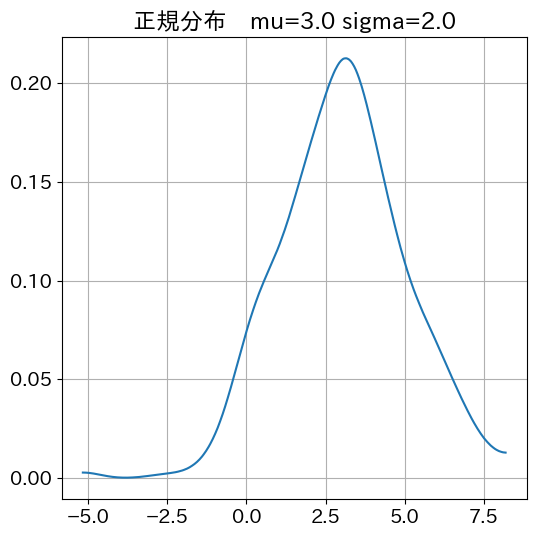

In [15]:
# パラメータ設定
mu = 3.0
sigma = 2.0

model5 = pm.Model()
with model5:
    # pm.Normal: 正規分布
    # mu:平均
    # sigma:標準偏差
    x = pm.Normal("x", mu=mu, sigma=sigma)

    # サンプリング
    prior_samples5 = pm.sample_prior_predictive(random_seed=42)

# サンプル値抽出
x_samples5 = prior_samples5["prior"]["x"].values
# 桁数が多いので先頭100個だけに限定
print(x_samples5[:, :100])

# サンプリング結果の可視化
ax = az.plot_dist(x_samples5)
ax.set_title(f"正規分布　mu={mu} sigma={sigma}")

Text(0.5, 1.0, '正規分布\u3000mu=3.0 sigma=2.0')

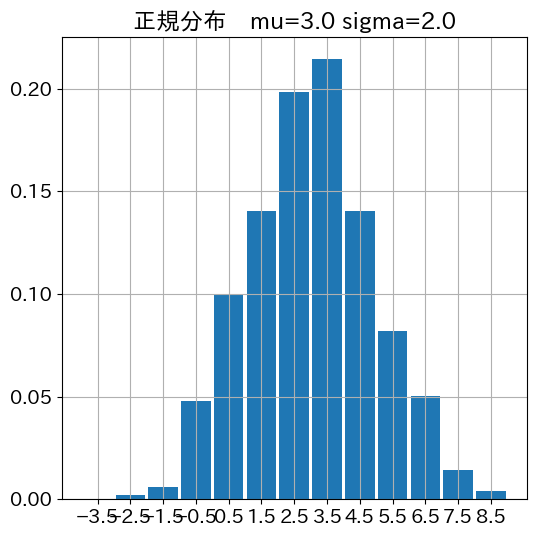

In [16]:
bins = np.arange(-4, 10, 1.0)
az.plot_dist(x_samples5, kind="hist", hist_kwargs={"bins": bins})
plt.title(f"正規分布　mu={mu} sigma={sigma}")

In [17]:
summary5 = az.summary(prior_samples5, kind="stats")
display(summary5)

,mean,sd,hdi_3%,hdi_97%
x,3.018,1.927,-0.180,6.801


In [19]:
# パラメータ設定
lower = 0.0
upper = 1.0
# lower, upper は一様分布（Uniform distribution）の区間 [lower, upper] を決めるパラメータ。
#
# 連続一様分布 U(a, b) の確率密度関数 (PDF) は
#
#   f(x) =
#     1 / (b - a)    （a ≤ x ≤ b のとき）
#     0             （それ以外）
#
# で与えられる。
#
# 今回は
#
#   a = lower = 0.0
#   b = upper = 1.0
#
# なので、
#
#   X ∼ Uniform(0, 1)
#
# という「区間 [0,1] 上で一様な」連続分布になる。
# この分布は、確率論・統計学・ベイズ推論においてよく使われる基本的な分布であり、
# 特に「0〜1 の確率」「比率」「割合」に対する非情報的な事前分布の近似として扱われることが多い。
#
# 一様分布 U(0,1) の理論値としては、
#
#   E[X]      = (a + b) / 2 = 0.5
#   Var(X)    = (b - a)^2 / 12 = 1/12
#
# が成り立つ。

model6 = pm.Model()
# model6 は PyMC における「確率モデル全体を保持するコンテナ」。
# 理論的には、この中に
#
#   X ∼ Uniform(0, 1)
#
# という確率変数を 1 つ持つモデル
#
#   𝓜: X ~ U(0, 1)
#
# を定義していると解釈できる。
# これをベースにして、
#   - 事前サンプル（sample_prior_predictive）
#   - 事後サンプル（sample）
#   - 事後予測サンプル（sample_posterior_predictive）
# などのベイズ推論上の操作を行っていくことになる。

with model6:
    # with model6: に入ることで、このブロックの中で定義される確率変数は
    # すべて model6 に「所属する」ことが PyMC に伝えられる。
    # これにより、変数同士の依存関係や、後続のサンプリング処理が
    # 正しいモデルに対して実行されるようになる。

    # pm.Uniform: 一様分布に従う連続確率変数を定義する分布クラス。
    # 理論的には、
    #
    #   X ∼ Uniform(lower, upper)
    #
    # すなわち
    #
    #   f(x) = 1 / (upper - lower)   （lower ≤ x ≤ upper）
    #          0                      （それ以外）
    #
    # という密度関数を持つ連続確率変数 X を導入している。
    #
    # lower: 下限値 a
    # upper: 上限値 b
    #
    # であり、区間 [a, b] の外では密度が 0 になる。
    # 今回は [0, 1] なので、密度は
    #
    #   f(x) = 1   （0 ≤ x ≤ 1）
    #
    # と非常にシンプルになる（区間長が 1 のため 1/(b - a) = 1）。
    #
    # このような U(0,1) 分布は、ベイズ推論において
    #   - 確率パラメータ p の「非情報的」事前（本当の非情報的ではないが簡便な近似）
    #   - 他の分布のパラメータに対する「範囲だけを制約した弱い事前」
    # としてしばしば使われる。
    #
    # 例えば、
    #   p ∼ Uniform(0, 1)
    #   X | p ∼ Binomial(n, p)
    # のようなモデルは、p に Beta(1,1)（= U(0,1)）の事前を置いたベータ–二項モデルと
    # ほぼ同じ発想とみなせる。
    #
    # 'x' という名前は、この確率変数にアクセスするためのラベルであり、
    #   prior_samples['prior']['x']
    #   posterior_samples['posterior']['x']
    # のように、ArviZ/PyMC の InferenceData からサンプルを取り出すときのキーとして使われる。
    x = pm.Uniform("x", lower=lower, upper=upper)

Sampling: [x]


[[0.917 0.911 0.877 0.309 0.955 0.175 0.997 0.752 0.150 0.383 0.579 0.175
  0.249 0.928 0.450 0.080 0.929 0.015 0.745 0.508 0.161 0.427 0.810 0.851
  0.069 0.578 0.135 0.559 0.724 0.776 0.313 0.629 0.076 0.612 0.763 0.669
  0.018 0.894 0.681 0.058 0.213 0.882 0.621 0.136 0.728 0.789 0.318 0.037
  0.078 0.508 0.517 0.226 0.348 0.956 0.873 0.573 0.951 0.652 0.883 0.697
  0.983 0.929 0.646 0.409 0.709 0.553 0.627 0.078 0.042 0.248 0.068 0.389
  0.040 0.106 0.610 0.511 0.483 0.768 0.640 0.827 0.080 0.072 0.733 0.562
  0.195 0.413 0.392 0.450 0.510 0.663 0.474 0.235 0.078 0.695 0.373 0.022
  0.568 0.860 0.420 0.253]]


Text(0.5, 1.0, '一様分布 lower=0.0 upper=1.0')

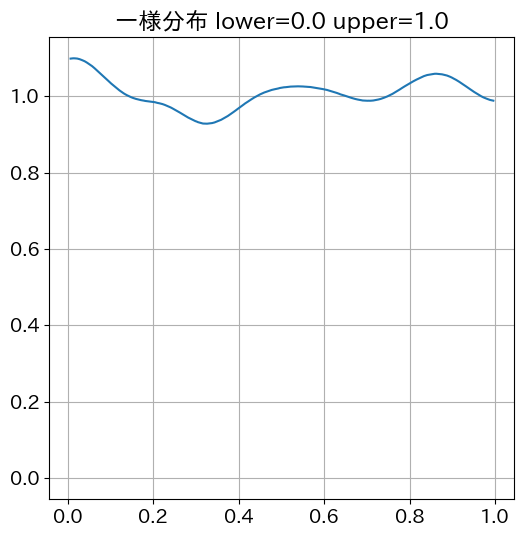

In [20]:
with model6:
    # サンプリング
    # sample_prior_predictive は「事前予測分布」からのサンプルを生成する関数。
    #
    # 一般のベイズモデルでは
    #   θ ∼ p(θ)                （パラメータの事前分布）
    #   X ∼ p(X | θ)            （データ生成分布／尤度）
    # と書けるとき、事前予測分布は
    #
    #   p(x) = ∫ p(x | θ) p(θ) dθ
    #
    # で定義される。
    #
    # 今回の model6 ではパラメータ θ に相当するものを持たず、
    # 直接
    #   X ∼ Uniform(lower, upper)
    # すなわち
    #   X ∼ Uniform(0, 1)
    # の 1 変量モデルとして定義している。
    #
    # 区間 [0, 1] 上の一様分布 U(0,1) の密度関数 f(x) は
    #   f(x) = 1   （0 ≤ x ≤ 1）
    #           0   （それ以外）
    # であり、事前予測分布 p(x) はそのままこの f(x) に一致する。
    #
    # 従って、ここでの sample_prior_predictive は
    #   X^(s) ∼ Uniform(0, 1)
    # というサンプル列 { X^(s) } を生成している操作に対応する。
    prior_samples6 = pm.sample_prior_predictive(random_seed=42)

# サンプル値抽出
# prior_samples6 は InferenceData 形式になっており、
# 'prior' グループの 'x' というラベルの下に
#   X^(s) ∼ Uniform(0, 1)
# からの事前サンプルが格納されている。
#
# x_samples6 はこのサンプルを NumPy 配列として取り出したもので、
# 各要素は区間 [0,1] のどこかの実数値となる。
# 理論的には、これらの値の経験分布が
#   f(x) = 1（0 ≤ x ≤ 1）
# に近づいていくことが期待される。
x_samples6 = prior_samples6["prior"]["x"].values

# 桁数が多いので先頭100個だけに限定して表示
# ここで出力される値はすべて [0,1] の範囲にあるはずであり、
# 標本数を増やすと「0〜1 の間にまんべんなく散らばる」様子が見て取れる。
# 統計的には、これは「連続一様分布 U(0,1) の標本列」を直接眺めていることになる。
print(x_samples6[:, :100])

# サンプリング結果の可視化
# az.plot_dist(x_samples6) は、x_samples6 の経験分布を可視化する。
#
# 一様分布 U(0,1) の理論的な PDF は
#   f(x) = 1（0 ≤ x ≤ 1）、それ以外は 0
# という「高さ一定の長方形」である。
#
# サンプル数を十分に大きくすると、ヒストグラムや KDE によって推定された
# 経験的な密度関数 f̂(x) は、この理論的な長方形に近い形になる。
# これは、
#   - 大数の法則：経験分布が真の分布に収束する
#   - 連続一様分布の「バラつきのなさ」（区間内で完全に対称・平坦）
# を視覚的に確認する機会となる。
#
# 今回は kind を明示していないので、環境に応じて密度推定やヒストグラムが描かれるが、
# いずれにせよ x_samples6 が U(0,1) らしい振る舞いをしているかをチェックする用途に使える。
ax = az.plot_dist(x_samples6)

# グラフタイトルには lower, upper の値を明示することで、
# この分布が
#   X ∼ Uniform(lower, upper)
# のサンプルであることが一目で分かるようにしている。
# 今後、区間を変えて Uniform(a,b) を試す場合にも、
# タイトルにパラメータを含めておくと比較がしやすくなる。
ax.set_title(f"一様分布 lower={lower} upper={upper}")

Text(0.5, 1.0, '一様分布 lower=0.0 upper=1.0')

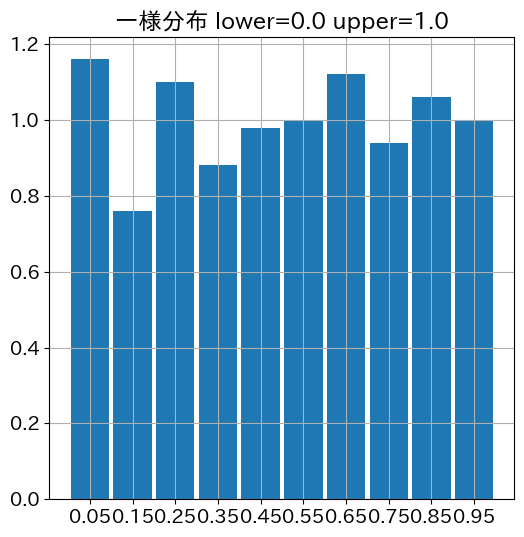

In [21]:
# 一様分布のヒストグラム用ビンの設定
# bins = np.arange(0.0, 1.1, 0.1) は、
#
#   [0.0, 0.1, 0.2, ..., 1.0]
#
# という 0.1 刻みのビン境界を定義している。
# ここで扱っている事前分布は
#
#   X ∼ Uniform(0, 1)
#
# であり、理論的な確率密度関数は
#
#   f(x) =
#     1              （0 ≤ x ≤ 1）
#     0              （それ以外）
#
# である。
#
# 一様分布 U(0,1) のもとで、任意の区間 [a, b] ⊂ [0,1] に対して
#
#   P(a ≤ X ≤ b) = b - a
#
# が成り立つため、今回の 0.1 幅のビン [0.0, 0.1), [0.1, 0.2), ... に対しては
#
#   P(k/10 ≤ X < (k+1)/10) = 0.1
#
# がすべての k = 0,1,...,9 で同じ値になる。
# したがって、理論的には「全ビンの高さが同じ」ヒストグラムになるはずである。
bins = np.arange(0.0, 1.1, 0.1)

# ArviZ によるヒストグラム描画
# az.plot_dist に kind='hist' を指定することで、
# サンプル列 x_samples6 のヒストグラムを描画している。
#
# x_samples6 は前ステップで
#
#   X^(s) ∼ Uniform(0, 1)
#
# から生成された事前サンプルの集合 {X^(s)} に対応する。
# hist_kwargs={'bins': bins} によって、上で定義した 0.1 幅のビンを
# そのままヒストグラムに適用している。
#
# サンプル数を S とすると、各ビン j に入る標本数を N_j としたとき、
#
#   相対頻度   N_j / S
#
# は真の確率 P(bin j) の推定値となる。
# U(0,1) の場合は P(bin j) = 0.1 なので、
# 大数の法則により S → ∞ のとき
#
#   N_j / S → 0.1
#
# がほぼ確実に成り立つ。
# このヒストグラムは、その収束の様子を有限サンプルで可視化していると解釈できる。
ax = az.plot_dist(x_samples6, kind="hist", hist_kwargs={"bins": bins})

# グラフタイトル設定
# タイトルに lower, upper を含めることで、
#
#   X ∼ Uniform(lower, upper)
#
# すなわちここでは
#
#   X ∼ Uniform(0, 1)
#
# に従うサンプルの経験分布を描いていることが明示されている。
# 理論的には、
#   - 各ビンの棒の高さがほぼ同じであること
#   - 0 未満や 1 超の領域には棒が現れないこと
# を確認することで、一様分布 U(0,1) の性質
#
#   ・区間内で「どこも同じ確率密度」
#   ・区間外の確率密度は 0
#
# がサンプルレベルで再現されているかどうかをチェックできる。
ax.set_title(f"一様分布 lower={lower} upper={upper}")

In [24]:
# 一様分布 U(0,1) に従う事前サンプルの要約統計量を計算
# prior_samples6 は、モデル
#
#   X ∼ \mathrm{Uniform}(0, 1)
#
# から sample_prior_predictive によって生成された事前サンプルを含んでいる。
# 一様分布 U(a,b) の理論的なモーメントは
#
# $$\mathbb{E}[X] = \frac{a + b}{2}$$
#
# $$\mathrm{Var}(X) = \frac{(b - a)^2}{12}$$
#
# で与えられるので、今回の a=0, b=1 の場合には
#
# $$\mathbb{E}[X] = \frac{0 + 1}{2} = 0.5$$
#
# $$\mathrm{Var}(X) = \frac{(1 - 0)^2}{12} = \frac{1}{12} \approx 0.0833$$
#
# $$\mathrm{SD}(X) = \sqrt{\mathrm{Var}(X)} = \sqrt{\frac{1}{12}} \approx 0.2887$$
#
# となる。
#
# az.summary(prior_samples6, kind='stats') は、この理論値に対応する
# 「サンプルからの推定値」を計算する役割を持つ。
# 具体的には、事前サンプル列
#
# $$\{X^{(s)}\}_{s=1}^S$$
#
# に対して、
#
# - mean 列: 標本平均
#
#   $$\hat{\mu} = \frac{1}{S}\sum_{s=1}^S X^{(s)}$$
#
# - sd 列: 標本標準偏差
#
#   $$\widehat{\mathrm{SD}}(X)
#   = \sqrt{\frac{1}{S-1}\sum_{s=1}^S\bigl(X^{(s)} - \hat{\mu}\bigr)^2}$$
#
# - hdi_xx 列: 高密度区間（Highest Density Interval; HDI）
#
# などをまとめて返す。
#
# サンプルサイズ S を大きくすると、大数の法則により
#
# $$\hat{\mu} \to \mathbb{E}[X] = 0.5$$
#
# $$\widehat{\mathrm{SD}}(X) \to \sqrt{\mathrm{Var}(X)} \approx 0.2887$$
#
# となることが期待されるため、summary6 の値がこれらにどれくらい近いかを見ることで、
# 「PyMC による U(0,1) サンプリングが理論と整合しているか」を数値的にチェックすることができる。
summary6 = az.summary(prior_samples6, kind="stats")

# 事前サンプルの要約統計量を表形式で表示
# display(summary6) によって、Jupyter 上で表形式の出力が得られる。
# ここで特に注目すべき点は次の通り：
#
# - mean が理論値 0.5 に近いかどうか
# - sd が理論値 √(1/12) ≈ 0.2887 に近いかどうか
# - hdi_xx（例えば 3%〜97% HDI）が、おおよそ [0,1] の内部に
#   「ほぼ一様な形」で広がっているかどうか
#
# である。
#
# U(0,1) の場合、区間全体で密度が一定であるため、HDI も「端から端までなめらかに広がる」
# 形になりやすく、他の分布（例えば正規分布のように中央付近に質量が集中する分布）の HDI と
# 見比べると、一様分布の特徴が視覚的にも比較しやすい。
#
# ベイズモデリングのワークフローの中では、これは
#
# - 「事前分布そのものの振る舞いを、サンプルの統計量という観点からチェックしている」
#
# ステップに相当する。
# この段階で、事前分布が自分のモデリング意図（例えば「値は [0,1] の間でどこも同じくらいあり得る」
# という仮定）と噛み合っているかを確認しておくことが、後続の事後推論や予測解釈の信頼性に直結する。
display(summary6)

,mean,sd,hdi_3%,hdi_97%
x,0.502,0.289,0.037,0.956


Sampling: [x]


[[0.833 0.829 0.801 0.347 0.864 0.240 0.897 0.702 0.220 0.407 0.563 0.240
  0.299 0.842 0.460 0.164 0.843 0.112 0.696 0.507 0.229 0.442 0.748 0.781
  0.156 0.563 0.208 0.547 0.679 0.721 0.350 0.603 0.161 0.590 0.710 0.635
  0.114 0.815 0.645 0.147 0.271 0.806 0.597 0.209 0.683 0.731 0.354 0.130
  0.162 0.507 0.514 0.281 0.378 0.865 0.798 0.558 0.861 0.622 0.806 0.657
  0.887 0.843 0.616 0.427 0.667 0.542 0.602 0.163 0.133 0.299 0.154 0.411
  0.132 0.184 0.588 0.509 0.487 0.715 0.612 0.762 0.164 0.157 0.687 0.550
  0.256 0.431 0.413 0.460 0.508 0.630 0.479 0.288 0.163 0.656 0.398 0.118
  0.555 0.788 0.436 0.303]]


Text(0.5, 1.0, '一様分布 lower=0.1 upper=0.9')

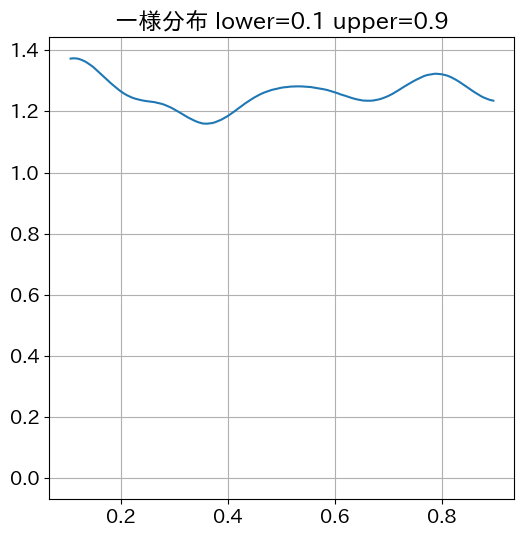

In [22]:
# パラメータ設定
lower = 0.1
upper = 0.9

model7 = pm.Model()
with model7:
    # pm.Uniform: 一様分布
    # lower: 下限値
    # upper: 上限値
    x = pm.Uniform("x", lower=lower, upper=upper)

    # サンプリング
    prior_samples7 = pm.sample_prior_predictive(random_seed=42)

# サンプル値抽出
x_samples7 = prior_samples7["prior"]["x"].values
print(x_samples7[:, :100])

# サンプリング結果の可視化
ax = az.plot_dist(x_samples7)
ax.set_title(f"一様分布 lower={lower} upper={upper}")

Text(0.5, 1.0, '一様分布 lower=0.1 upper=0.9')

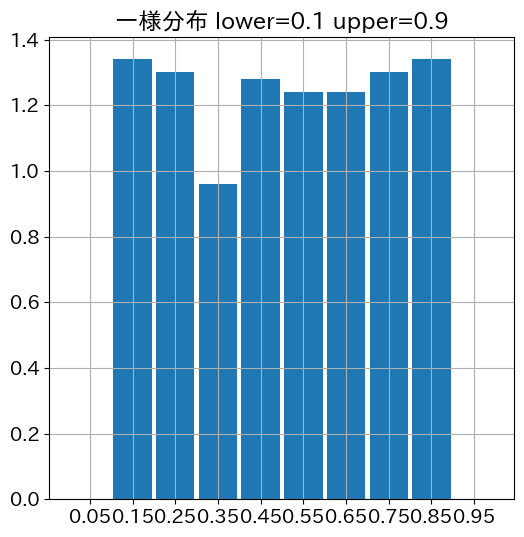

In [23]:
bins = np.arange(0.0, 1.1, 0.1)
ax = az.plot_dist(x_samples7, kind="hist", hist_kwargs={"bins": bins})
ax.set_title(f"一様分布 lower={lower} upper={upper}")

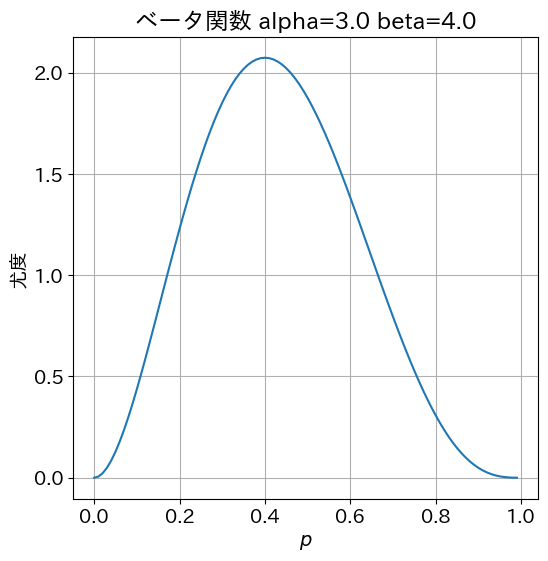

In [26]:
from math import gamma
import numpy as np
import matplotlib.pyplot as plt

# パラメータ定義
# alpha, beta はベータ分布 Beta(α, β) の形状パラメータ（shape parameters）を表す。
# 一般に、ベータ分布
#
#   p ∼ Beta(α, β)
#
# の確率密度関数 (PDF) は
#
#   f(p | α, β) = 1 / B(α, β) * p^(α-1) (1-p)^(β-1),   0 < p < 1
#
# で定義される。ここで B(α, β) はベータ関数で、
#
#   B(α, β) = Γ(α) Γ(β) / Γ(α + β)
#
# である。
#
# このコードでは alpha, beta を
#   alpha = 2.0 + 1.0
#   beta  = 3.0 + 1.0
# としており、これは典型的には
#   - 事前パラメータ α_0 = 2, β_0 = 3
#   - 観測データとして成功 1 回・失敗 0 回（あるいはその逆）
# のような状況で posterior のパラメータを
#
#   α = α_0 + 成功回数
#   β = β_0 + 失敗回数
#
# の形で更新したもの、と解釈できる（ベータ–二項モデルの共役更新のイメージ）。
alpha = 2.0 + 1.0
beta = 3.0 + 1.0


# ベータ分布風の関数の定義
# ここで定義している Beta(p, alpha, beta) は、厳密には「数学的な意味でのベータ関数」ではなく、
# ベータ分布 Beta(α, β) の PDF と非常によく似た形を持つ関数である。
#
# 理論的に標準的なベータ分布の PDF は
#
#   f(p | α, β)
#   = 1 / B(α, β) * p^(α-1) (1-p)^(β-1)
#   = Γ(α + β) / (Γ(α) Γ(β)) * p^(α-1) (1-p)^(β-1)
#
# だが、ここでは正規化定数 C を
#
#   C = Γ(α + β - 1) / (Γ(α - 1) Γ(β - 1))
#
# としている点に注意。
# これは
#
#   1 / B(α - 1, β - 1)
#
# に対応する形になっており、「(α, β) ではなく (α-1, β-1) をパラメータとするベータ分布」の
# 正規化定数に相当する。
# つまり、
#
#   C * p^(α-1) (1-p)^(β-1)
#
# は、標準的な Beta(α, β) ではなく Beta(α-1, β-1) に関連した形を持つことになる。
# グラフの形はベータ分布型になるが、厳密な意味での Beta(α, β) とは少しずれていることを
# 理論的注意点として押さえておくとよい。
def Beta(p, alpha, beta):
    C = gamma(alpha + beta - 1) / (gamma(alpha - 1) * gamma(beta - 1))
    return C * p ** (alpha - 1) * (1 - p) ** (beta - 1)


# グラフ描画用 x 座標の定義
# 0.0 < p < 1.0
# ベータ分布（およびここで定義した Beta(p, α, β)）の定義域は 0 < p < 1 なので、
# プロット用の p を
#
#   p ∈ [0, 1)
#
# の細かい格子点として生成する。
# np.arange(0.0, 1.0, 0.01) により、
#   0.00, 0.01, 0.02, ..., 0.99
# のような刻み幅 0.01 の離散点列を得て、その各点で Beta(p, α, β) を評価する。
p = np.arange(0.0, 1.0, 0.01)

# グラフ描画
# Beta(p, alpha, beta) を p ∈ (0,1) にわたって描画することで、
# ベータ分布型の密度関数の形を可視化している。
#
# alpha = 3, beta = 4（2+1, 3+1）の場合、
# 成功の「擬似カウント」が 3、失敗の「擬似カウント」が 4 に対応するため、
# p の小さい値（0〜0.5 付近）に重心を持つ左にやや偏った分布になる。
plt.plot(p, Beta(p, alpha, beta))
plt.title(f"ベータ関数 alpha={alpha} beta={beta}")

# x 軸ラベル
# 本来ここには、「確率パラメータ p」や「ベルヌーイ試行の成功確率 θ」など、
# p が「何の確率」を表しているかを明示するラベルを入れるとよい。
# 以前のコードでは plt.xlabel(r'\n') となっており、改行だけを含む raw 文字列が
# 閉じていない状態になっていたため SyntaxError（unterminated string literal）が出ていた。
# ここでは x 軸に「確率 p」を表す LaTeX 数式ラベルを正しく指定している。
plt.xlabel(r"$p$")

# y 軸ラベル
# y 軸は「確率密度 f(p)」であり、ベイズ的には
#   - 二項モデルのパラメータに対する事前分布／事後分布
#   - 尤度の形に比例する関数
# などとして解釈される。
# ここではラベル名として便宜的に「尤度」としているが、
# 厳密には「（正規化定数の扱いに注意が要る）ベータ分布型の密度」という意味合いである。
plt.ylabel("尤度")

plt.show()

In [27]:
# パラメータ設定
# ここでの alpha, beta はベータ分布の形状パラメータ（shape parameters）であり、
#
#   p ~ Beta(α, β)
#
# を規定する。ベータ–二項モデル（Beta-Binomial）の文脈では、
#
#   - α - 1 : 「成功」の擬似カウント
#   - β - 1 : 「失敗」の擬似カウント
#
# として解釈できる。
#
# 今回は
#
#   alpha = 2.0 + 1.0
#   beta  = 3.0 + 1.0
#
# としているので、「成功 2 回ぶん」「失敗 3 回ぶん」の事前情報を持つような
# ベータ分布 Beta(3,4) を仮定しているイメージになる。
# （実際には 2.0, 3.0 は連続値なので「厳密な回数」ではないが、
#  直感的には成功・失敗の“擬似データ”として理解できる。）
alpha = 2.0 + 1.0
beta = 3.0 + 1.0

# PyMC の Model オブジェクトを生成
# model8 は、このあと定義する確率変数や尤度などをまとめる
# 「確率モデル全体」を表すコンテナ。
#
# 理論的には、
#
#   ℳ₈ : p ~ Beta(α, β)
#
# という事前分布を持つモデルの「入れ物」を作っている段階と解釈できる。
model8 = pm.Model()

with model8:
    # with model8: のコンテキストに入ることで、
    # このブロック内で定義されるすべての確率変数が
    # model8 に紐づくことが PyMC に伝わる。
    # その結果、
    #
    #   pm.sample()                  → 事後分布サンプリング
    #   pm.sample_prior_predictive() → 事前予測サンプリング
    #
    # 等を呼び出したときに、この model8 に対して処理が行われる。
    #
    # pm.Beta: ベータ分布に従う連続確率変数を定義する分布クラス。
    # 理論的には
    #
    #   p ~ Beta(α, β)
    #
    # すなわち確率密度関数
    #
    #   f(p | α, β)
    #     = 1 / B(α, β) * p^(α-1) (1-p)^(β-1),   0 < p < 1
    #
    # を持つ事前分布を導入していることになる。
    #
    # コメント
    #   alpha: くじに当たった回数 + 1
    #   beta : くじにはずれた回数 + 1
    # は、ベータ–二項モデルの共役更新
    #
    #   事前:    p ~ Beta(α₀, β₀)
    #   尤度:    X | p ~ Binomial(n, p)
    #   事後:    p | X = k ~ Beta(α₀ + k, β₀ + n - k)
    #
    # を意識したものになっている。
    # ここでは、その「更新後パラメータ」(α, β) を直接指定して
    # 事前（あるいは事後）分布としての Beta(α, β) をモデルに組み込んでいる、と見なせる。
    #
    # 'p' という名前は、この確率変数にアクセスするためのラベルであり、
    #   - サンプリング結果の InferenceData から
    #       prior['p'], posterior['p']
    #     のように参照するためのキー
    #   - 後で定義する尤度（例: Binomial のパラメータ）から参照されるパラメータ
    # として機能する。
    p = pm.Beta("p", alpha=alpha, beta=beta)

Sampling: [p]


[[0.478 0.778 0.745 0.639 0.689 0.182 0.314 0.431 0.472 0.491 0.764 0.209
  0.659 0.398 0.361 0.357 0.478 0.359 0.413 0.690 0.768 0.479 0.237 0.154
  0.286 0.583 0.231 0.492 0.248 0.549 0.377 0.435 0.635 0.457 0.690 0.563
  0.237 0.724 0.540 0.141 0.489 0.594 0.480 0.218 0.316 0.736 0.246 0.087
  0.447 0.532 0.362 0.203 0.189 0.300 0.219 0.576 0.309 0.381 0.670 0.196
  0.284 0.351 0.386 0.691 0.549 0.536 0.440 0.412 0.501 0.808 0.528 0.360
  0.485 0.374 0.588 0.266 0.662 0.469 0.620 0.299 0.840 0.284 0.672 0.734
  0.324 0.326 0.516 0.221 0.721 0.675 0.265 0.177 0.445 0.313 0.302 0.199
  0.483 0.575 0.528 0.389]]


Text(0.5, 1.0, 'ベータ分布\u3000alpha=3.0 beta=4.0')

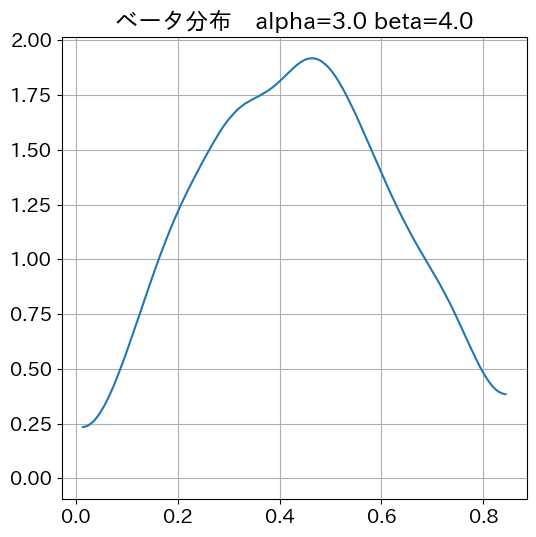

In [28]:
with model8:
    # サンプリング
    # sample_prior_predictive は「事前予測分布（prior predictive）」からのサンプルを生成する関数。
    #
    # 一般には、パラメータ θ に事前分布 p(θ) をおき、観測データ x の生成分布（尤度） p(x | θ)
    # を定めると、事前予測分布は
    #
    #   $$p(x) = \int p(x \mid \theta)\, p(\theta)\, d\theta$$
    #
    # で与えられる。
    #
    # 今回の model8 では、まだ尤度（観測データ x のモデル）を導入しておらず、
    # まずはパラメータ p に対する事前分布
    #
    #   $$p \sim \mathrm{Beta}(\alpha,\ \beta)$$
    #
    # だけを定義している。
    # よって、この時点での「事前予測サンプル」は、厳密には
    # 「パラメータ p 自身の事前分布からのサンプル」を見ていることに相当する。
    #
    # PyMC の InferenceData では、これらが 'prior' グループに格納される。
    prior_samples8 = pm.sample_prior_predictive(random_seed=42)

# サンプル値抽出
# prior_samples8['prior']['p'] には、
#   $$p \sim \mathrm{Beta}(\alpha,\ \beta)$$
# からの事前サンプルが格納されている。
#
# .values で NumPy 配列として取り出すと、通常は形状
#
#   (draws, chains, ...)
#
# のような多次元配列になっている。
# ここでは分布の形を確認するだけなので、そのまま p_samples8 を可視化に用いる。
p_samples8 = prior_samples8["prior"]["p"].values

# 桁数が多いので先頭100個だけに限定して表示
# ここで表示される値の一つ一つが、「Beta(α, β) からサンプルされた p の値」であり、
# ベイズ的には「事前にどのような確率値 p をどの程度あり得ると考えているか」を
# 乱数列として具体的に見ていることになる。
print(p_samples8[:, :100])

# サンプリング結果の可視化
# az.plot_dist(p_samples8) によって、事前サンプル {p^(s)} の経験分布を可視化する。
#
# ベータ分布
#
#   $$p \sim \mathrm{Beta}(\alpha,\ \beta)$$
#
# の理論的な平均と分散は
#
#   $$\mathbb{E}[p] = \frac{\alpha}{\alpha + \beta}$$
#
#   $$\mathrm{Var}(p) = \frac{\alpha \beta}{(\alpha + \beta)^2 (\alpha + \beta + 1)}$$
#
# で与えられる。
# 今回の α=3, β=4（2+1, 3+1）の場合、
#
#   $$\mathbb{E}[p] = \frac{3}{3 + 4} = \frac{3}{7} \approx 0.4286$$
#
# となるため、プロットされる分布の「山」は 0.4 付近に位置し、
# p=0〜1 の範囲内でやや左寄り（「成功確率は 0.5 未満寄り」と考えている）な形状になるはずである。
#
# このプロットは、
#   - 選んだベータ事前分布が直感と一致しているか
#   - 「成功 2 回、失敗 3 回ぶんの擬似データ」を事前に埋め込んだとき、
#     どのような p の値をどの程度あり得ると見なすのか
# を視覚的にチェックするためのものと解釈できる。
ax = az.plot_dist(p_samples8)

# タイトルには alpha, beta の値を明示しておくことで、
# 後から他のパラメータ（例: Beta(1,1), Beta(10,2) など）と比較したときに、
# どの図がどの事前分布に対応しているかをすぐに識別できる。
ax.set_title(f"ベータ分布　alpha={alpha} beta={beta}")

Text(0.5, 1.0, 'ベータ分布\u3000alpha=3.0 beta=4.0')

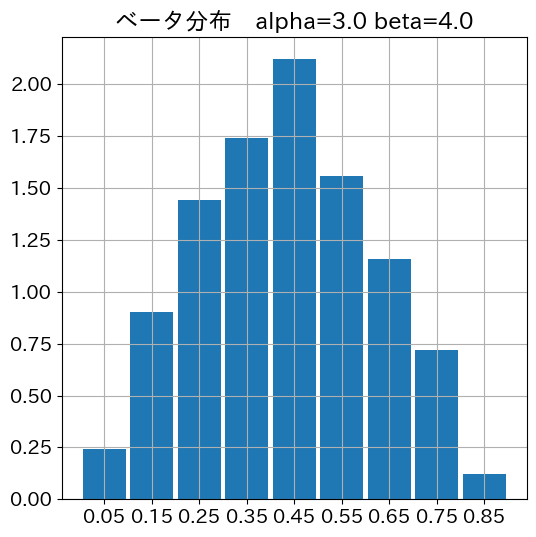

In [29]:
# ベータ分布から得られた事前サンプル p_samples8 のヒストグラムを描画するコード

# bins の定義
# np.arange(0, 1.0, 0.1) により、
#   0.0, 0.1, 0.2, ..., 0.9
# という 0.1 刻みのビン境界を生成している。
#
# この bins は「ビンの境界値（端点）」として解釈されるため、
# 区間 [0, 1) を
#
#   [0.0, 0.1), [0.1, 0.2), ..., [0.8, 0.9)
#
# のように等幅に分割したヒストグラムが描かれるイメージになる。
# （※1.0 ちょうどの点を明示的に含めたい場合は、例えば np.arange(0, 1.1, 0.1) のように
#  右端を 1.0 を超える値にする、という設計もあり得る。）
#
# ここで可視化している p_samples8 は
#
#   p ~ Beta(α, β)
#
# からのサンプル列なので、このヒストグラムは
# 「ベータ分布の形状を標本分布として近似したもの」とみなすことができる。
bins = np.arange(0, 1.0, 0.1)

# ArviZ による分布の可視化（ヒストグラム）
# az.plot_dist に kind='hist' を指定することで、
# 与えたサンプル列 p_samples8 に対するヒストグラムを描画している。
#
# p_samples8 は事前分布
#
#   p ~ Beta(α, β)
#
# のサンプル列 { p^{(s)} } に対応し、その理論的な密度関数は
#
#   f(p | α, β) = 1 / B(α, β) * p^(α-1) (1-p)^(β-1),   0 < p < 1
#
# である。
# ヒストグラムは、標本の相対度数を高さとすることで、
# この f(p | α, β) を「離散的に近似したもの」として解釈できる。
#
# Beta(3,4)（今回の α=3, β=4）の場合、理論的平均は
#
#   E[p] = α / (α + β) = 3 / 7 ≈ 0.4286
#
# となるため、ヒストグラムの山も 0.4 付近に位置し、
# p=0〜1 の範囲内で「0.5 よりやや小さい値」が多めに出現するような形状になるはずである。
ax = az.plot_dist(p_samples8, kind="hist", hist_kwargs={"bins": bins})

# グラフタイトルの設定
# タイトルに alpha, beta の値を含めることで、
# このヒストグラムが
#
#   p ~ Beta(alpha, beta)
#
# の事前サンプルに対応していることが一目で分かるようになっている。
# 今後、異なる事前（例: Beta(1,1), Beta(10,2) など）と比較する際にも、
# どの図がどの事前パラメータに対応するかを素早く識別できる点で有用である。
ax.set_title(f"ベータ分布　alpha={alpha} beta={beta}")

In [30]:
# ベータ分布からの事前サンプル prior_samples8 に対する要約統計量を計算
# prior_samples8 は、モデル
#
#   p ~ Beta(α, β)
#
# に対して pm.sample_prior_predictive で生成したサンプル群を InferenceData として
# 保持しているオブジェクト。
#
# ここで az.summary(prior_samples8, kind='stats') を呼ぶことで、
#   - 各変数（ここでは事前分布のパラメータ p）の
#   - サンプルに基づく要約統計量（mean, sd, hdi など）
# を一括で計算する。
#
# 理論的には、ベータ分布 Beta(α, β) のモーメントは
#
#   期待値（平均）:
#     E[p] = α / (α + β)
#
#   分散:
#     Var(p) = αβ / ((α + β)^2 (α + β + 1))
#
# であり、今回の α=3, β=4 の場合には
#
#   E[p] = 3 / (3 + 4) = 3/7 ≈ 0.4286
#
#   Var(p) = 3 * 4 / (7^2 * 8) = 12 / 392 = 3 / 98 ≈ 0.0306
#
#   SD(p) = sqrt(Var(p)) ≈ sqrt(0.0306) ≈ 0.1749
#
# となるはずである。
#
# az.summary で得られる
#   - mean 列  → 標本平均 \hat{μ}
#   - sd 列    → 標本標準偏差 \widehat{SD}
# は、ベイズ的には
#
#   「事前分布からの有限サンプルで数値的に推定した E[p], SD(p)」
#
# とみなせるので、上の理論値（0.4286, 約 0.175）とどれくらい近いかを確認することで、
#
#   - サンプリング実装が理論と整合しているか
#   - サンプル数が統計的に十分か（ばらつきがどれくらいあるか）
#
# といった観点をチェックできる。
summary8 = az.summary(prior_samples8, kind="stats")

# 事前サンプルの要約統計量を表形式で表示
# display(summary8) によって、Jupyter 上で DataFrame の形で
#   - mean（標本平均）
#   - sd（標本標準偏差）
#   - hdi_xx（高密度区間; Highest Density Interval）
# などが確認できる。
#
# 特にこのケースでは、
#   - mean が理論値 E[p] = 3/7 ≈ 0.4286 に近いか
#   - sd が理論値 SD(p) ≈ 0.175 に近いか
#   - hdi_3%, hdi_97% などの区間が「0〜1 の間で、0.4 付近を中心に適度な広がりを持っているか」
# を見ることで、「Beta(3,4) という事前のイメージ（成功より失敗に少し重みを置いた分布）が
# サンプルレベルでも再現されているか」を確認できる。
#
# ベイズモデリングの実務的な観点では、
#   - 事前分布が想定外に“鋭すぎないか”（過度に情報的ではないか）
#   - 逆に、あまりにも広すぎて解析上の意味が薄くなっていないか
# といった点を、この種の要約統計と可視化（ヒストグラムなど）を組み合わせてチェックすることが重要になる。
display(summary8)

,mean,sd,hdi_3%,hdi_97%
p,0.433,0.181,0.120,0.760


Sampling: [p]


[[0.423 0.540 0.509 0.482 0.510 0.310 0.363 0.403 0.420 0.432 0.535 0.324
  0.474 0.396 0.381 0.379 0.421 0.381 0.398 0.491 0.533 0.423 0.341 0.287
  0.351 0.461 0.329 0.422 0.344 0.452 0.387 0.408 0.476 0.415 0.495 0.454
  0.336 0.523 0.446 0.281 0.428 0.456 0.424 0.586 0.494 0.371 0.380 0.493
  0.458 0.428 0.412 0.369 0.567 0.509 0.453 0.324 0.472 0.396 0.354 0.427
  0.526 0.432 0.429 0.336 0.380 0.355 0.413 0.365 0.273 0.421 0.317 0.348
  0.422 0.469 0.386 0.338 0.484 0.315 0.354 0.396 0.411 0.242 0.428 0.345
  0.387 0.339 0.445 0.424 0.328 0.295 0.425 0.519 0.465 0.323 0.463 0.476
  0.457 0.368 0.298 0.413]]


Text(0.5, 1.0, 'ベータ分布\u3000alpha=21.0 beta=31.0')

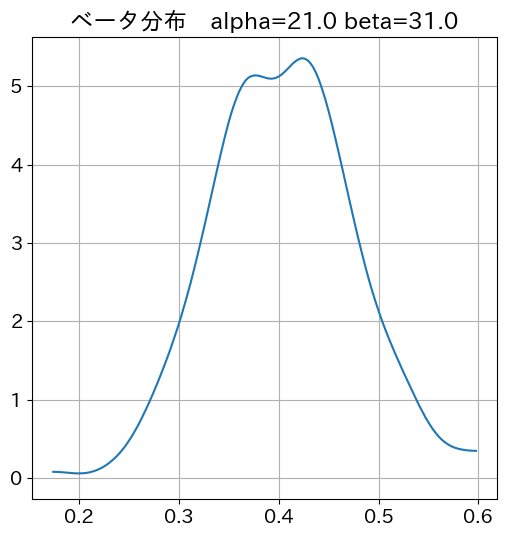

In [31]:
# パラメータ設定
# ここでの alpha, beta はベータ分布の形状パラメータ（shape parameters）であり、
#
#   p ~ Beta(α, β)
#
# を規定する。
# ベータ–二項モデル（Beta-Binomial）の文脈では、
#
#   - α - 1 : 「成功」の擬似カウント
#   - β - 1 : 「失敗」の擬似カウント
#
# として解釈できる。
#
# 今回は
#
#   alpha = 20.0 + 1.0
#   beta  = 30.0 + 1.0
#
# としているので、
#
#   - 事前に「成功が 20 回ぶん」
#   - 事前に「失敗が 30 回ぶん」
#
# の情報を持つようなベータ分布 Beta(21,31) を仮定しているイメージになる。
# 先ほどの Beta(3,4) と比べて「擬似データの総数」が 7 → 52 と増えているため、
# 分布は平均付近により強く集中し、事前がかなり“情報的”（informative）になる。
alpha = 20.0 + 1.0
beta = 30.0 + 1.0

# PyMC の Model オブジェクトを生成
# model9 は、確率変数や尤度をまとめる「確率モデル全体」のコンテナ。
model9 = pm.Model()

with model9:
    # pm.Beta: ベータ分布に従う連続確率変数を定義する分布クラス。
    # 理論的には
    #
    #   p ~ Beta(α, β)
    #
    # すなわち確率密度関数
    #
    #   f(p | α, β)
    #     = 1 / B(α, β) * p^(α-1) (1-p)^(β-1),   0 < p < 1
    #
    # を持つ事前分布を導入している。
    #
    # コメント
    #   alpha: 注目している試行の成功数 + 1
    #   beta : 注目している試行の失敗数 + 1
    # は、ベータ–二項モデルの共役更新則
    #
    #   事前:    p ~ Beta(α₀, β₀)
    #   尤度:    X | p ~ Binomial(n, p)
    #   事後:    p | X = k ~ Beta(α₀ + k, β₀ + n - k)
    #
    # を意識したものになっている。
    # 現在のコードは、その「更新後パラメータ」(α, β) を直接指定して、
    # 事前（あるいは事後）分布として Beta(21,31) をモデルに埋め込んでいる状態と見なせる。
    p = pm.Beta("p", alpha=alpha, beta=beta)

    # サンプリング
    # sample_prior_predictive は「事前予測サンプリング」を行う関数。
    #
    # 一般には、パラメータ θ に事前分布 p(θ)、観測データ x に尤度 p(x | θ) を定めると、
    # 事前予測分布は
    #
    #   p(x) = ∫ p(x | θ) p(θ) dθ
    #
    # で定義されるが、
    # 現状の model9 では「パラメータ p の事前分布」しか定義しておらず、
    # 尤度（データ x のモデル）はまだ導入していない。
    #
    # したがって、この時点での sample_prior_predictive は、
    # 実質的には
    #
    #   p ~ Beta(α, β)
    #
    # から事前サンプル { p^(s) } を生成していると解釈できる。
    # これらのサンプルは InferenceData の 'prior' グループに格納される。
    prior_samples9 = pm.sample_prior_predictive(random_seed=42)

# サンプル値抽出
# prior_samples9['prior']['p'] には、
#
#   p ~ Beta(α, β)
#
# からの事前サンプルが格納されている。
# .values で NumPy 配列として取り出し、
# 先頭 100 個だけを確認用に表示している。
#
# Beta(21,31) の理論的な平均・分散は
#
#   E[p] = α / (α + β) = 21 / (21 + 31) = 21 / 52 ≈ 0.4038
#
#   Var(p) = αβ / ((α + β)^2 (α + β + 1))
#          = 21 * 31 / (52^2 * 53)
#          ≈ 651 / (2704 * 53)
#          ≈ 0.0045
#
#   SD(p) ≈ sqrt(0.0045) ≈ 0.067
#
# となるので、表示されるサンプル列は「0.4 付近にかなり集中している」ことが期待される。
p_samples9 = prior_samples9["prior"]["p"].values
# 桁数が多いので先頭100個だけに限定
print(p_samples9[:, :100])

# サンプリング結果の可視化
# az.plot_dist(p_samples9) によって、事前サンプル { p^(s) } の経験分布を可視化する。
#
# 先ほど扱った Beta(3,4) と比較すると、
#   - 平均は 3/7 ≈ 0.4286 から 21/52 ≈ 0.4038 へと少し左（小さい値）に移動
#   - 分散はかなり小さくなり、分布は平均付近に鋭く集中
# する。
#
# これは、「擬似カウント（成功 20, 失敗 30）を多く持つ事前」を入れたことで、
# 事前分布が観測データに対して強い影響力を持つ、というベイズ的な意味を視覚的に示している。
ax = az.plot_dist(p_samples9)
ax.set_title(f"ベータ分布　alpha={alpha} beta={beta}")

Text(0.5, 1.0, 'ベータ分布\u3000alpha=21.0 beta=31.0')

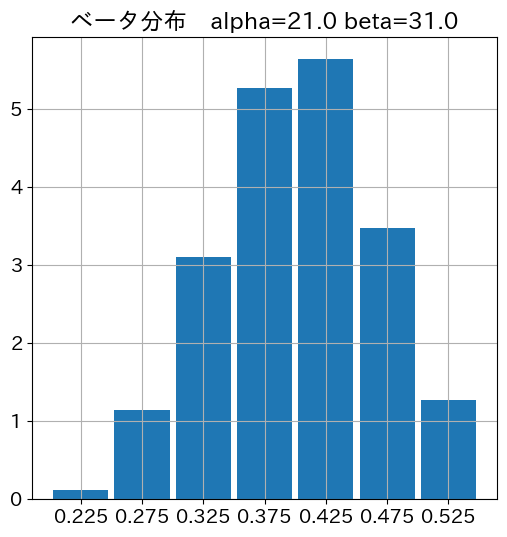

In [32]:
bins = np.arange(0.2, 0.6, 0.05)
ax = az.plot_dist(p_samples9, kind="hist", hist_kwargs={"bins": bins})
ax.set_title(f"ベータ分布　alpha={alpha} beta={beta}")

In [33]:
summary9 = az.summary(prior_samples9, kind="stats")
display(summary9)

,mean,sd,hdi_3%,hdi_97%
p,0.403,0.068,0.281,0.534


In [34]:
# パラメータ設定
# sigma は半正規分布 HalfNormal の「元になる正規分布」の標準偏差に対応するパラメータ。
#
# 半正規分布 X ~ HalfNormal(σ) は、正規分布 N(0, σ²) を 0 で折り返して
# 「x >= 0 の部分だけを取って正規化し直した」分布として定義される。
#
# 具体的な確率密度関数 (PDF) は
#
#   f(x | σ)
#     = √(2 / π) * 1/σ * exp( - x² / (2 σ²) ),   x >= 0
#     = 0,                                      x < 0
#
# となる。
#
# ベイズモデリングでは、
#   - 標準偏差や分散の平方根など「スケール（大きさ）」を表すパラメータ
#   - 「負の値を取り得ない量」（ノイズの大きさ、振幅、分散の平方根など）
# に対する事前分布としてよく使われる。
sigma = 1.0

# PyMC の Model オブジェクトを生成
# model10 は、これから定義する確率変数 x（半正規事前）を含む
# ベイズモデル全体のコンテナを表す。
model10 = pm.Model()

with model10:
    # pm.HalfNormal: 半正規分布に従う連続確率変数を定義する分布クラス。
    #
    # 理論的には、
    #
    #   X ~ HalfNormal(σ)
    #
    # すなわち、
    #
    #   X = |Z|,   Z ~ N(0, σ²)
    #
    # のように、平均 0・分散 σ² の正規分布 Z の絶対値として表現できる。
    # その密度は
    #
    #   f(x | σ)
    #     = √(2 / π) * 1/σ * exp( - x² / (2 σ²) ),   x >= 0
    #
    # であり、x < 0 では 0 となる（定義域が x >= 0 に制限される点が、通常の正規分布との違い）。
    #
    # ベイズ推論の文脈では、以下のような使われ方が典型的である：
    #
    #   - 回帰モデルや階層ベイズモデルでの「誤差項の標準偏差 σ」に対する事前：
    #
    #       σ ~ HalfNormal(σ₀)
    #
    #   - 各階層のランダム効果のスケール τ に対する事前：
    #
    #       τ ~ HalfNormal(τ₀)
    #
    #   - 「値は必ず 0 以上で、0 付近も許容するが“大きくなりすぎる”ことは抑制したい」
    #     というようなスケールパラメータ全般
    #
    # 今回はまだ尤度や他のパラメータと結びついていないので、
    #
    #   「X は 0 以上で、だいたい N(0,1²) を折り返した程度のスケール」
    #
    # を持つ事前を単独で導入している段階と解釈できる。
    # 後でこの x を、ノイズの標準偏差や階層分散などに接続することで、
    # ベイズモデル全体のスケールに関する事前として機能させることができる。
    x = pm.HalfNormal("x", sigma=sigma)

Sampling: [x]


[[0.418 0.606 0.029 1.084 1.464 0.291 1.331 0.035 0.280 0.107 1.921 1.579
  1.006 0.451 0.593 0.094 1.852 0.256 0.283 0.416 1.089 1.967 0.887 1.328
  0.132 0.362 0.782 0.283 1.006 0.019 1.243 2.603 0.151 0.516 0.220 0.402
  1.361 0.743 0.937 0.175 1.525 0.098 1.165 0.524 1.066 0.311 0.556 0.100
  0.258 1.590 1.815 0.536 1.271 0.554 1.724 0.312 0.063 1.382 0.585 0.510
  0.251 0.406 0.866 0.534 0.039 1.143 0.464 2.267 0.529 0.325 0.154 0.820
  1.203 0.095 1.362 0.277 0.307 1.404 1.539 1.597 1.268 0.744 1.379 0.373
  0.225 0.797 0.190 0.405 1.567 1.622 0.559 1.285 0.649 0.642 2.170 0.549
  0.032 0.744 1.306 0.870]]


Text(0.5, 1.0, '半正規分布\u3000sigma=1.0')

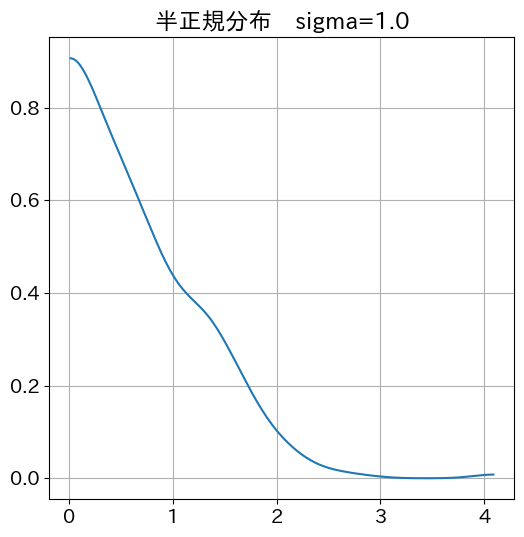

In [35]:
with model10:
    # サンプリング
    # sample_prior_predictive は「事前予測サンプリング」を行う関数。
    #
    # 一般形では、パラメータ θ に事前分布 p(θ) を置き、
    # 観測データ x に対して尤度 p(x | θ) を定めると、
    # 事前予測分布は
    #
    #   p(x) = ∫ p(x | θ) p(θ) dθ
    #
    # で定義される。
    #
    # しかし、この model10 では現時点で「半正規分布に従うパラメータ x」のみが定義されており、
    # 観測データのモデル（尤度）は導入していない。
    # そのため、今回の sample_prior_predictive は実質的に
    #
    #   x ~ HalfNormal(σ)
    #
    # からの事前サンプル { x^(s) } を生成していると解釈できる。
    # これらのサンプルは InferenceData の 'prior' グループに格納される。
    prior_samples10 = pm.sample_prior_predictive(random_seed=42)

# サンプル値抽出
# prior_samples10['prior']['x'] には、
#
#   x ~ HalfNormal(σ)
#
# に従う事前サンプル列が格納されている。
# .values で NumPy 配列として取り出すと、
# 通常は (chains, draws, ...) という形状の配列になる。
x_samples10 = prior_samples10["prior"]["x"].values

# 桁数が多いので先頭100個だけに限定
# ここで印字される各値 x^(s) は、
#
#   x^(s) >= 0
#
# を満たし、元の正規分布 N(0, σ²) の絶対値をとったような分布に従う。
# HalfNormal(σ=1) の理論的なモーメントは
#
#   E[X] = σ * √(2/π)  ≈ 1 * 0.7979 ≈ 0.798
#   Var(X) = σ² (1 - 2/π) ≈ 1 * (1 - 0.6366) ≈ 0.3634
#
# であるため、サンプルの多くは 0 付近から 2 程度までの範囲に集中することが期待される。
print(x_samples10[:, :100])

# サンプリング結果の可視化
# az.plot_dist(x_samples10) は、事前サンプル { x^(s) } の経験分布を可視化する。
#
# 半正規分布 HalfNormal(σ) は、元の正規 N(0, σ²) を 0 で折り返した分布なので、
# 密度の形は x >= 0 の側で
#
#   f(x | σ) ∝ exp( - x² / (2 σ²) )
#
# となり、x=0 に最大値を持ち、x が大きくなるにつれて指数関数的に減衰する。
#
# したがって、プロットされる分布は
#   - x=0 付近で最も高く
#   - 右に向かってなだらかに下がる
# という非対称な形をとる（通常の正規分布 N(0,1) の右半分だけを見ているイメージ）。
#
# ベイズモデリングでは、このような半正規事前は、
#   - 標準偏差やスケールパラメータ（必ず 0 以上）の事前
#   - ノイズの大きさやランダム効果の振幅
# に対して「0 付近も許容するが、極端に大きな値は抑制したい」というときに好んで使われる。
ax = az.plot_dist(x_samples10)

# タイトルには σ を明示することで、
# 「HalfNormal(σ=1) の事前分布から得たサンプルの分布」であることが一目で分かるようにしている。
# 後で σ を 0.5, 2.0 などに変えた場合の分布との比較にも役立つ。
ax.set_title(f"半正規分布　sigma={sigma}")

In [36]:
# カイ2乗分布の確率密度関数を扱うためのコード
# （np が未インポートなら以下が必要）
# import numpy as np


# カイ2乗分布 (chi-square distribution) ν = 3 の確率密度関数 (PDF) を定義
#
# 一般に、自由度 ν のカイ2乗分布の PDF は
#
#   f(x; ν)
#     = 1 / (2^{ν/2} Γ(ν/2)) x^{ν/2 - 1} exp(-x/2),   x > 0
#
# で与えられる。
# ν = 3 の場合には
#
#   f(x; 3)
#     = 1 / (2^{3/2} Γ(3/2)) x^{1/2} exp(-x/2)
#
# となるが、
#
#   Γ(3/2) = √π / 2
#
# であることから分母は
#
#   2^{3/2} Γ(3/2)
#     = 2^{3/2} * (√π / 2)
#     = 2^{1/2} √π
#     = √(2π)
#
# となる。
# よって
#
#   f(x; 3)
#     = (1 / √(2π)) * √x * exp(-x/2)
#
# と書ける。
#
# 下の qui_square(x) では、定数 1/√(2π) を
#
#   w = x / (2π)  →  √w = √x / √(2π)
#
# の形に埋め込むことで、
#
#   f(x; 3) = √(x/(2π)) * exp(-x/2)
#
# を実装している。
def qui_square(x):
    w = x / (2 * np.pi)  # w = x / (2π) とおくことで、√w = √x / √(2π) が得られる
    return np.sqrt(w) * np.exp(-x / 2)  # f(x;3) = √(x/(2π)) exp(-x/2)


# x1, x2 は「両側 10% ずつの外側確率」を切り落とすような閾値を
# ヒューリスティックに決めたものと解釈できる。
#
# カイ2乗分布の CDF を F(x) とすると、
#
#   a1 = ∫_0^{x1} f(x;3) dx ≈ 0.1
#   a2 = ∫_{x2}^{∞} f(x;3) dx ≈ 0.1
#
# となるような x1, x2 を数値的に求めたい、あるいはそれに近い値を使いたい、
# という状況を想定している。
#
# このコードでは、その候補として
#
#   x1 = 0.585
#   x2 = 6.25
#
# を「ヒューリスティックに」選び、それに対して実際に積分してみて
# どれくらい 0.1 に近いかを確認している。
x1 = 0.585
x2 = 6.25

# 数値積分でグラフの面積を計算
# （scipy が未インポートなら以下が必要）
# from scipy import integrate
#
# integrate.quad(f, a, b) は、関数 f(x) の ∫_a^b f(x) dx を数値的に求める。
# 戻り値は (積分値, 誤差推定) のタプル。
#
# a1 = ∫_0^{x1} f(x;3) dx
# a2 = ∫_{x2}^{∞} f(x;3) dx
#
# を求めることで、
#
#   - 左側の裾の確率質量がどれくらいか
#   - 右側の裾の確率質量がどれくらいか
#
# を数値的に評価している。
# 上側積分では無限大の代わりに 1000 を上限としているが、
# カイ2乗分布の ν=3 では x が数十を超えるあたりから密度がほとんど 0 に近くなるので、
# 1000 まで積分すれば「実質的に ∞ マイナスとみなせる範囲」になっている。
from scipy import integrate

a1, _err1 = integrate.quad(qui_square, 0, x1)  # 左側 0〜x1 の累積確率
a2, _err2 = integrate.quad(
    qui_square, x2, 1000
)  # 右側 x2〜∞ の累積確率（∞ を 1000 で近似）

# a = [a1, a2] として左裾・右裾の確率を並べる。
# 理想的には両方とも 0.1 に近い値になっていれば、
# x1, x2 が「カイ2乗分布 ν=3 の両側 10% カット点（≒ 80% 信頼区間の境界）」に近いと判断できる。
a = np.array([a1, a2])
print(a)

[0.100 0.100]


Text(0.5, 1.0, 'CI (confidence interval)の考え方')

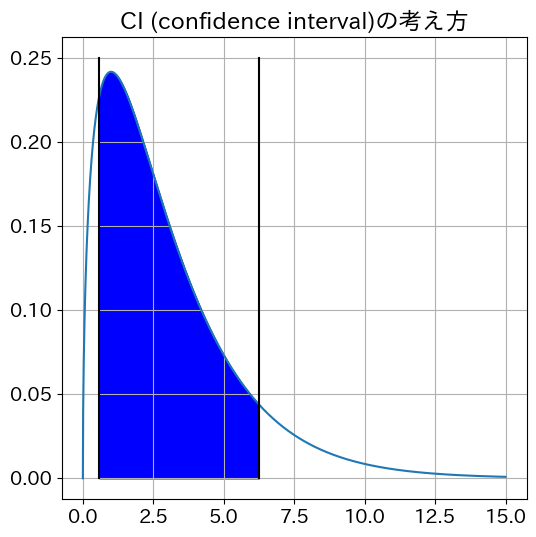

In [37]:
# カイ2乗分布 ν=3 の確率密度関数 qui_square(x) と、
# 左右の閾値 x1, x2（おおよそ両側 10% ずつの外側確率になるように選んだ値）が
# すでに定義されていることを前提とした可視化コード。

# x 軸用に 0〜15 の範囲を 0.01 刻みで離散化
# ここでの 15 という上限は「カイ2乗分布 ν=3 の質量のほとんどが含まれる」程度の
# 十分大きな値として選ばれている（実際、x が大きくなると exp(-x/2) により密度は急速に 0 に近づく）。
x = np.arange(0.0, 15, 0.01)

# 論理配列 x_between は「x1 < x < x2 を満たすかどうか」を要素ごとに持つブール配列。
# すなわち、
#   True  : 信頼区間 (x1, x2) の “内側” にある x
#   False : それ以外（両側の裾）の x
# を表す。
#
# ここで x1, x2 は前のセルで
#
#   a1 = ∫_0^{x1} f(x;3) dx ≈ 0.1,
#   a2 = ∫_{x2}^{∞} f(x;3) dx ≈ 0.1
#
# となるようヒューリスティックに選んだ値であり、
# (x1, x2) は「中央 80% 程度の確率質量を含む区間」の近似として解釈できる。
x_between = (x1 < x) & (x < x2)

# y はカイ2乗分布 ν=3 の PDF を x 上で評価した値
#   y = f(x; ν=3)
# であり、前のセルで定義した
#
#   qui_square(x) = sqrt(x / (2π)) * exp(-x/2)
#
# を用いて計算している。
y = qui_square(x)

# まずカイ2乗分布の PDF 曲線を描画
plt.plot(x, y)

# fill_between を用いて、x1〜x2 の区間だけを塗りつぶす。
# where=x_between により、
#   x1 < x < x2
# を満たす領域でのみ 0 から y(x) までの面積を塗ることで、
# 「中央の信頼区間部分」の確率質量を視覚的に強調している。
#
# 統計的には、この色付き部分が
#   P(x1 < X < x2)
# を表し、前セルの数値積分の結果から「おおよそ 0.8（= 1 - 0.1 - 0.1）」になるように
# x1, x2 が選ばれている、というストーリーになっている。
plt.fill_between(x, 0, y, where=x_between, color="b")

# x = x1 の位置に縦線を描画。
# (0, 0.25) という y 範囲で線を引いているのは、グラフの「基準線」として見やすくするため。
# この線は「左側 10% の確率を切り落とす境界（下側 10% 点）」を表す。
plt.plot((x1, x1), (0, 0.25), c="k")

# x = x2 の位置にも同様に縦線を描画。
# この線は「右側 10% の確率を切り落とす境界（上側 10% 点）」を表す。
plt.plot((x2, x2), (0, 0.25), c="k")

# タイトル設定
# “CI (confidence interval) の考え方” というタイトルから分かるように、
# この図全体は「両側の裾 10% を捨てて、中央 80% を信頼区間とみなす」という
# 両側信頼区間（two-sided confidence interval）の概念を、カイ2乗分布 ν=3 を例に
# 直感的に説明するためのものである。
#
# 実務では、例えば分散に関する信頼区間などで
#
#   X ~ χ²(ν)
#
# の分布の両側 2.5% ずつ（合計 5%）を切り落とした 95% 信頼区間
#   [χ²_{α/2, ν}, χ²_{1-α/2, ν}]
# を使う、といった形で応用される。
plt.title("CI (confidence interval)の考え方")

In [38]:
from scipy import optimize


# h(x) は「カイ2乗分布 ν=3 の確率密度が 0.05 になる点」を求めるための関数。
#
# すでに定義済みの qui_square(x) は、
#
#   X ~ χ²(ν=3)
#
# の確率密度関数
#
#   f(x; 3) = √(x/(2π)) exp(-x/2)
#
# に対応している（定数の扱いは前セルの通り）。
#
# ここで h(x) = f(x;3) - 0.05 とおくと、
#
#   h(x) = 0  ⇔  f(x;3) = 0.05
#
# となるので、「密度が 0.05 になる x の値（レベルセットの境界）」を
# root-finding（零点探索）によって求めることができる。
def h(x):
    return qui_square(x) - 0.05


# optimize.fsolve は、方程式 h(x)=0 の解 x を
# ニュートン法系のアルゴリズム（多次元 fsolve は Newton-Krylov 系）で数値的に求める関数。
#
# 第2引数に「初期値」を与えることで、
#   - どの解（どの根）に収束させるか
#   - 近くに存在する根を探しに行く
# という挙動になる。
#
# カイ2乗分布 ν=3 の PDF f(x;3) は、
#   - x > 0 で 0 から立ち上がり、ある点で最大値をとったあと、
#   - x → ∞ で 0 に減衰する
# という一峰性の関数なので、
# 「f(x;3)=0.05 を満たす点」は一般に 2 つ存在する（左側の根と右側の根）。
#
# そこで初期値を
#   - 0.0 付近：左側の根（小さい x の解）に収束させる
#   - 5.0 付近：右側の根（大きい x の解）に収束させる
# という意図で 2 回 fsolve を呼び出している。
#
# この 2 つの解を x_L, x_R とすると、
#
#   f(x_L;3) = f(x_R;3) = 0.05
#
# となり、
#   - レベル 0.05 の「等高線」に対応する x の位置
#   - その間 (x_L, x_R) で f(x;3) > 0.05, それより外側で f(x;3) < 0.05
# を特徴づけることができる。
#
# 信頼区間の観点から見ると、このようなレベルセットは
#   - 「密度がある閾値以上の領域」を Highest Density Interval (HDI) 的に捉える
#   - あるいは CI の境界の近似として使う
# といったアイディアにもつながる。
print(optimize.fsolve(h, 0.0))  # 左側の解（小さい x 側の根）を探索
print(optimize.fsolve(h, 5.0))  # 右側の解（大きい x 側の根）を探索

[0.016]
[5.934]


Text(0.5, 1.0, 'HDI (highest density interval)の考え方')

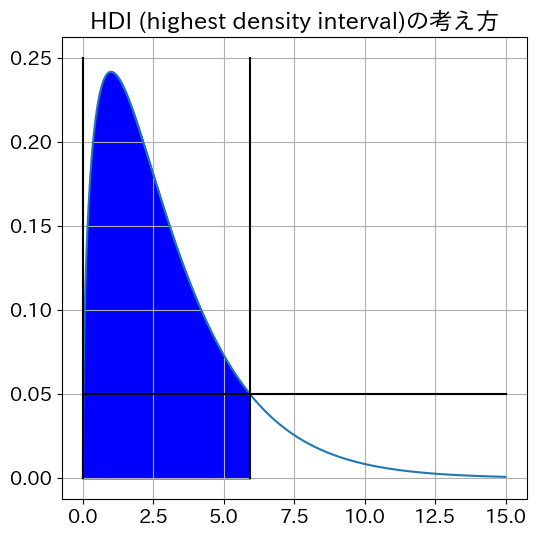

In [39]:
# ここでは、カイ2乗分布 ν=3 の確率密度関数 qui_square(x) を用いて
# 「HDI (highest density interval：最高密度区間)」のイメージを可視化している。
#
# HDI はベイズ統計でよく使われる「事後分布の不確実性の表現」で、
#   - ある確率質量（例：0.8 や 0.95）を含む区間のうち
#   - その区間内ではどこも「密度が区間外より低くない」
# という条件を満たす区間を指す。
#
# 直感的には、「もっとも尤もらしい値（密度が高い領域）から順に塗りつぶしていき、
# 合計で所定の確率質量に達したところで切った区間」が HDI になる。
#
# このコードでは、その考え方を
#   - 閾値 y = 0.05 を固定し、
#   - f(x;3) > 0.05 となる領域 [x1, x2] を塗りつぶす
# という形で表現している。

# x 軸を 0〜15 の範囲で 0.01 刻みの格子点として定義。
# カイ2乗分布 ν=3 の密度は x が大きくなると exp(-x/2) により急速に 0 に近づくため、
# x=15 まであれば分布の「見た目上の裾」はほぼ含まれている。
x = np.arange(0.0, 15, 0.01)

# x1, x2 は「密度が 0.05 になる点」に近い値。
# 前のセルで f(x;3) - 0.05 = 0 の解を fsolve で求めた結果から、
#   x1 ≒ 0.02, x2 ≒ 5.93
# となることが分かっているので、それをここで直接代入している。
#
# このとき、
#   f(x1;3) ≒ f(x2;3) ≒ 0.05
# であり、区間 (x1, x2) の内部では f(x;3) > 0.05、
# その外側では f(x;3) < 0.05 となる。
#
# したがって (x1, x2) は「密度が 0.05 を下回らない領域」の境界として、
# HDI 的な区間の一例として解釈できる。
x1 = 0.02
x2 = 5.93

# カイ2乗分布 ν=3 の PDF を評価
# qui_square(x) は
#   f(x;3) = sqrt(x / (2π)) * exp(-x/2)
# を実装しており、x > 0 で χ²(3) の形になっている（定数の扱いは前セル参照）。
y = qui_square(x)

# PDF 曲線を描画
plt.plot(x, y)

# HDI の「中身」に相当する部分を塗りつぶす。
# np.logical_and(x > x1, x < x2) により、
#   x1 < x < x2
# を満たす点だけを True とするブール配列を作り、
# その区間の 0〜y(x) の面積を青色で塗る。
#
# こうすることで、
#   - 「密度が高い中心部分」が強調され
#   - その領域がどのくらいの幅（x1 から x2）を持つか
# が視覚的に分かる。
plt.fill_between(x, 0.0, y, where=np.logical_and(x > x1, x < x2), color="b")

# y = 0.05 の「水平線」を描画。
# これは「この高さ以上の密度を持つ x の集合」を HDI とみなす、という発想を表現している。
# 実際にはベイズの HDI は「密度が一定以上」という条件と「確率質量が所定値になる」という
# 2 つの条件を同時に満たすように閾値を調整するが、
# ここでは閾値 0.05 を固定して、その考え方を示している。
plt.plot((0, 15.0), (0.05, 0.05), c="k")

# 左側の境界 x = x1 に縦線を描画。
# この点で f(x;3) ≒ 0.05 となり、ここより左では
#   f(x;3) < 0.05
# となる。
# したがって、この線は「HDI（高密度領域）の左端」を表す。
plt.plot((x1, x1), (0, 0.25), c="k")

# 右側の境界 x = x2 にも同様に縦線を描画。
# ここで f(x;3) ≒ 0.05 となり、ここより右では
#   f(x;3) < 0.05
# となるため、「HDI の右端」を表す。
plt.plot((x2, x2), (0, 0.25), c="k")

# タイトル設定
# “HDI (highest density interval) の考え方” というタイトルの通り、
# この図は
#
#   - 密度がある閾値（ここでは 0.05）以上の領域を「もっとも尤もらしい値の集合」とみなす
#   - その内側 (x1, x2) が高密度区間に対応する
#
# というベイズ的な区間推定の考え方を、カイ2乗分布を例に視覚的に説明している。
#
# 信頼区間（CI）が「確率質量の一定割合を含む区間」であるのに対し、
# HDI は「密度が高い順に埋めていった結果として得られる区間」である、
# という概念的な違いを示す教材としても利用できる。
plt.title("HDI (highest density interval)の考え方")